In [93]:
#numpy, matplotlib, pandasのインポート
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import unicodedata
from matplotlib import rcParams
import seaborn as sns

# 欠損値補完(MICE)のためにインポート
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


#エンコーディングのためインポート
from sklearn.preprocessing import OneHotEncoder

# notebookの設定

# データフレームの最大表示行数、列数を広げる
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

# 図のサイズ
plt.rcParams["figure.figsize"]=(8,4)

# matplotlibのフォント
font = 'Yu Mincho'

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Meiryo']

#学習データ、テストデータの読み込み
train0 = pd.read_csv('dataset/train.csv')
test0 = pd.read_csv('dataset/test.csv')

In [94]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     3389 non-null   object 
 1   TypeofContact           3483 non-null   object 
 2   CityTier                3489 non-null   int64  
 3   DurationOfPitch         3368 non-null   object 
 4   Occupation              3489 non-null   object 
 5   Gender                  3489 non-null   object 
 6   NumberOfPersonVisiting  3489 non-null   float64
 7   NumberOfFollowups       3456 non-null   float64
 8   ProductPitched          3489 non-null   object 
 9   PreferredPropertyStar   3489 non-null   float64
 10  NumberOfTrips           3467 non-null   object 
 11  Passport                3489 non-null   int64  
 12  PitchSatisfactionScore  3489 non-null   int64  
 13  Designation             3489 non-null   object 
 14  MonthlyIncome           3433 non-null   

In [95]:
value_list = train0['Age'].tolist()
list(dict.fromkeys(value_list))


['50歳',
 '56歳',
 nan,
 '三十七歳',
 '48歳',
 '19歳',
 '47歳',
 '49歳',
 '33歳',
 '３１歳',
 '51歳',
 '46歳',
 '４９歳',
 '53才',
 '20歳',
 '25歳',
 '五十三歳',
 '20代',
 '44歳',
 '30歳',
 '34歳',
 '29歳',
 '30代',
 '41歳',
 '50代',
 '52歳',
 '22歳',
 '３６歳',
 '28歳',
 '25才',
 '五十一歳',
 '48才',
 '38才',
 '三十三歳',
 '42際',
 '５０代',
 '35才',
 '59歳',
 '四十三歳',
 '32歳',
 '４２才',
 '53歳',
 '58歳',
 '40代',
 '二十六歳',
 '52際',
 '54歳',
 '59才',
 '29才',
 '21才',
 '57歳',
 '37歳',
 '35歳',
 '36才',
 '38歳',
 '３７歳',
 '50才',
 '51才',
 '43歳',
 '四十歳',
 '26歳',
 '31歳',
 '27歳',
 '40歳',
 '３４歳',
 '40際',
 '21歳',
 '24才',
 '45歳',
 '36歳',
 '41才',
 '38際',
 '18歳',
 '39歳',
 '４６歳',
 '４０代',
 '５５歳',
 '58際',
 '24歳',
 '41際',
 '三十一歳',
 '52才',
 '３０代',
 '28才',
 '55際',
 '60代',
 '27際',
 '３２歳',
 '60歳',
 '五十四歳',
 '29際',
 '三十四歳',
 '４７歳',
 '37際',
 '二十四歳',
 '四十七歳',
 '58才',
 '39才',
 '23才',
 '３３歳',
 '４２歳',
 '４５歳',
 '３９歳',
 '５４歳',
 '55歳',
 '42歳',
 '３８歳',
 '47才',
 '５１歳',
 '３９才',
 '51際',
 '二十七歳',
 '30才',
 '２６歳',
 '４０歳',
 '36際',
 '三十歳',
 '23歳',
 '二十二歳',
 '37才',
 '３０歳',
 '２８歳',
 '34才',
 '五十歳

In [108]:
train1 = train0.drop(train0.columns[0],axis=1) 
test1 = test0.drop(test0.columns[0],axis=1)

train_x = train1.drop(['ProdTaken'], axis=1)
train_y = train1['ProdTaken']
test_x = test1

def preprocessing(train_x, test_x):
    # Age numeric
    def age_missing(input_str):
            if input_str is None or str(input_str) == 'nan':
                input_str = 0
            if '代' in str(input_str):
                input_str = input_str.replace('代', '')
            else:
                input_str = 0
            return int(input_str)
    
    def process_age(age):
        kanji_to_num = {'一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9,'十': 10, '百': 100, '千': 1000, '万': 10000,'零': 0, '〇': 0}
        
        def kanji_to_arabic(kanji):
            result = 0
            temp = 0
            for char in kanji:
                value = kanji_to_num.get(char, None)
                if value is not None:
                    if value < 10:
                        if temp == 0:
                            temp = value
                        else:
                            temp = temp * 10 + value
                    elif value >= 10:
                        if temp == 0:
                            temp = 1
                        result += temp * value
                        temp = 0
            return result + temp
        if age is None or str(age) == 'nan' or '代' in str(age):
            return None
        age = unicodedata.normalize('NFKC', age)
        age = ''.join([c for c in age if c.isdigit() or c in kanji_to_num])
        if age.isdigit():
            return int(age)
        return kanji_to_arabic(age)

    # TypeofContact categorical(dummy)
    def TypeofContact_to_dummy(str):
        if str == 'Self Enquiry':
            return 1
        elif str == 'Company Invited':
            return 0
        
    # CityTier 順序尺度
    def CityTier_dealing(input_int):
        return 2 - input_int
    
    # DurationOfPitch numeric
    def convert_to_minutes(duration):
        # durationがfloat型またはNoneである可能性があるため、文字列であることを確認
        if pd.isnull(duration):
            return None  # NaNの場合、Noneを返す
        duration = str(duration)  # 文字列に変換してエラーを防ぐ
        if '分' in duration:
            return float(duration.replace('分', ''))
        elif '秒' in duration:
            return float(duration.replace('秒', '')) / 60  # 秒を分に変換し、整数で返す

    # Occupation categorical
    def Occupation_dealing(str):
        if str == 'Large Business':
            return 0
        elif str == 'Small Business':
            return 1
        elif str == 'Salaried':
            return 2
       
    # Gender categorical
    def Gender_dealing(gender):
        # 文字列を半角に変換し、大文字に統一
        gender = unicodedata.normalize('NFKC', gender).upper().strip()
        # 不要な空白を削除
        gender = ''.join(gender.split())

        if 'FEMALE' in gender:
            return 0
        elif 'MALE' in gender:
            return 1
        else:
            return None  # 性別が識別できない場合はNoneを返す
        
    # NumberOfPersonVisiting numeric
    
    # NumberOfFollowups numeric
    def NumberOfFollowups_dealing(input_int):
        if input_int >= 100:
            input_int = input_int / 100
        return input_int
    
    # ProductPitched categorical
    # Designation categorical
    def standardize_str(input_str):
        # 文字列を半角に変換し、小文字に統一
        input_str = unicodedata.normalize('NFKC', input_str).lower().strip()
        # 不要な空白や特殊記号を削除
        input_str = ''.join(input_str.split())
        input_str = input_str.replace('|', 'l').replace('×', 'x').replace('𝘤', 'c').replace('𝖺', 'a').replace('𝙳', 'd')
        # その他特殊文字を通常の英字に置換
        input_str = input_str.replace('ᗞ', 'd').replace('𐊡', 'a').replace('𝘳', 'r').replace('ꓢ', 's').replace('ı', 'i')
        input_str = input_str.replace('β', 'b').replace('в', 'b').replace('с', 'c').replace('տ', 's').replace('ς', 'c')
        input_str = input_str.replace('ꭰ', 'd').replace('ε', 'e').replace('ι', 'i').replace('α', 'a').replace('ո', 'n')
        input_str = input_str.replace('ѕ', 's').replace('μ', 'm').replace('е', 'e').replace('а', 'a').replace('ѵ', 'v')
        input_str = input_str.replace('aasic', 'basic')
        return input_str
    
    def ProductPitched_dealing(input_str):
        if input_str == 'basic':
            return 4
        elif input_str == 'standard':
            return 3
        elif input_str == 'deluxe':
            return 2
        elif input_str == 'superdeluxe':
            return 1
        elif input_str == 'king':
            return 0
        
    def Designation_dealing(input_str):
        if input_str == 'executive':
            return 4
        elif input_str == 'manager':
            return 3
        elif input_str == 'seniormanager':
            return 2
        elif input_str == 'avp':
            return 1
        elif input_str == 'vp':
            return 0
    
    # PreferredPropertyStar 順序尺度
    def PreferredPropertyStar_dealing(input_float):
        return 4.0 - input_float
    
    # NumberOfTrips numeric
    def NumberOfTrips_dealing(str):
        if pd.isnull(str):
            return None 
        if '半年に' in str:
            return 2 * int(str.replace('半年に', '').replace('回', ''))
        elif '年に' in str:
            return int(str.replace('年に', '').replace('回', ''))
        elif '四半期に' in str:
            return 4 * int(str.replace('四半期に', '').replace('回', ''))
        else :
            return int(str)
        
    # Passport categorical(dummy)
    
    # PitchSatisfactionScore 順序尺度だけど間隔尺度的要素あり
    def PitchSatisfactionScore_dealing(input_int):
        return 3 - input_int
    
    # MonthlyIncome numeric
    def MonthlyIncome_dealing(input_str):
        if pd.isnull(input_str):
            return None 
        if '月収' in input_str:
            return 10000 * float(input_str.replace('月収', '').replace('万円', ''))
        elif '万円' in input_str:
            return 10000 * float(input_str.replace('万円', ''))
        else:
            return float(input_str)
        
    # customer_info
    def customer_info_dealing(input_str):
        # 文字列を半角に変換し、小文字に統一
        input_str = unicodedata.normalize('NFKC', input_str).lower().strip()
        # 不要な空白や特殊記号を削除
        input_str = input_str.replace('/', ' ').replace('／', ' ').replace('、', ' ').replace('　', ' ')
        input_str = input_str.replace('\u3000', ' ').replace('\t', ' ').replace('\n', ' ')
        input_str = re.sub(r'(?<=\S)\s+(?=\S)', ',', input_str, count=2)
        return input_str
    
    # Married categorical
    def Married_dealing(input_str):
        if input_str == '独身':
            return 0
        elif input_str == '未婚':
            return 1
        elif input_str == '結婚済み':
            return 2
        if input_str == '離婚済み':
            return 3
    
    # CarPossesion categorival(dummy)
    def CarPossesion_dealing(input_str):
        if input_str in ['車未所持', '自動車未所有', '自家用車なし', '乗用車なし', '車なし', '車保有なし', 0]:
            return 0
        elif input_str in ['車所持', '自動車所有', '自家用車あり', '乗用車所持', '車保有', '車あり', 1]:
            return 1
        
    # NumberOfOffspring numeric
    def NumberOfOffspring_dealing(input_str):
        if '1' in input_str:
            return 1
        elif '2' in input_str:
            return 2
        elif '3' in input_str:
            return 3
        elif input_str in ['子供の数不明', '不明', 'わからない', '子育て状況不明', '子の数不詳']:
            return None
        else:
            return 0
        
    def dealing_default_features(input_df):
        df = input_df.copy()
        # df['AgeMissing'] = df['Age'].apply(age_missing)
        df['Age'] = df['Age'].apply(process_age)
        df['TypeofContact'] = df['TypeofContact'].apply(TypeofContact_to_dummy)
        df['CityTier'] = df['CityTier'].apply(CityTier_dealing)
        df['DurationOfPitch'] = df['DurationOfPitch'].apply(convert_to_minutes)
        df['Occupation'] = df['Occupation'].apply(Occupation_dealing)
        df['Gender'] = df['Gender'].apply(Gender_dealing)
        df['NumberOfFollowups'] = df['NumberOfFollowups'].apply(NumberOfFollowups_dealing)
        df['ProductPitched'] = df['ProductPitched'].apply(standardize_str).apply(ProductPitched_dealing)
        df['PreferredPropertyStar'] = df['PreferredPropertyStar'].apply(PreferredPropertyStar_dealing)
        df['NumberOfTrips'] = df['NumberOfTrips'].apply(NumberOfTrips_dealing)
        df['Designation'] = df['Designation'].apply(standardize_str).apply(Designation_dealing)
        df['PitchSatisfactionScore'] = df['PitchSatisfactionScore'].apply(PitchSatisfactionScore_dealing)
        df['MonthlyIncome'] = df['MonthlyIncome'].apply(MonthlyIncome_dealing)
        df['customer_info'] = df['customer_info'].apply(customer_info_dealing)
        df[['Married', 'CarPossesion', 'NumberOfOffspring']] = df['customer_info'].str.split(',', n=2, expand=True)
        df = df.drop(['customer_info'],axis=1)
        df['Married'] = df['Married'].apply(Married_dealing)
        df['CarPossesion'] = df['CarPossesion'].apply(CarPossesion_dealing)
        df['NumberOfOffspring'] = df['NumberOfOffspring'].apply(NumberOfOffspring_dealing)
        # df['IfChild'] = (df['NumberOfOffspring'] >= 1)
        # df['IfChild'] = df['IfChild'].astype(int)
        return df
    
    def column_addition(train_x, test_x, dummy_col):
        
        categorical_columns = ['TypeofContact', 'CityTier', 'Occupation', 'Gender', 'ProductPitched', 'PreferredPropertyStar', 'Passport', 'PitchSatisfactionScore', 'Designation', 'Married', 'CarPossesion']
        numeric_columns = ['Age', 'DurationOfPitch', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'NumberOfTrips', 'MonthlyIncome', 'NumberOfOffspring']
        tr_x = train_x.copy()
        te_x = test_x.copy()
#         for cols in itertools.combinations(categorical_columns, 2):
#             tr_x[f'{cols[0]}_{cols[1]}'] = tr_x[cols[0]].astype(str) + '_' + tr_x[cols[1]].astype(str)
#             te_x[f'{cols[0]}_{cols[1]}'] = te_x[cols[0]].astype(str) + '_' + te_x[cols[1]].astype(str)
#             dummy_col.append(f'{cols[0]}_{cols[1]}')

        def numerical_columns_addition(input_df):
            df = input_df
            def count_adult_members(input_str):
                if input_str == 2:
                    return 2
                else:
                    return 1
            def Single_dealing(input_int):
                if input_int == 0:
                    return 0
                else:
                    return 1

            df['Single'] = df['Married'].apply(Single_dealing)
            df['family_members'] = df['Married'].apply(count_adult_members) + df['NumberOfOffspring']
            df['MonthlyIncome / Age'] = df['MonthlyIncome'] / df['Age']
            # df['DurationOfPitch * NumberOfFollowups'] = df['DurationOfPitch'] * df['NumberOfFollowups']
            df['MonthlyIncome / family_members'] = df['MonthlyIncome'] / df['family_members']
            df['NumberOfPersonVisiting * NumberOfTrips'] = df['NumberOfPersonVisiting'] * df['NumberOfTrips']
            # df['DurationOfPitch * NumberOfPersonVisiting'] = df['DurationOfPitch'] * df['NumberOfPersonVisiting']
            df['Age / NumberOfTrips'] = df['Age'] / df['NumberOfTrips']
            df['PreferredPropertyStar / MonthlyIncome'] = df['PreferredPropertyStar'] / df['MonthlyIncome'] * 100000

            df['Income / child'] =  df['MonthlyIncome']/(df['NumberOfOffspring']+0.0001)
            df['MoneyforOneTrip'] = df['MonthlyIncome']*12/df['NumberOfTrips']
            df['AllOfcontact'] = df['DurationOfPitch'] + df['NumberOfFollowups']*2

            # df['SingleParent'] = ((df['Married'] == 3) & (df['NumberOfOffspring'] >= 1))
            # df['SingleParent'] = df['SingleParent'].astype(int)
            # df['Married_NoChild'] = ((df['Married'] == 2) & (df['NumberOfOffspring'] == 0))
            # df['Married_NoChild'] = df['Married_NoChild'].astype(int)
            # df['Married_Child'] = ((df['Married'] == 2) & (df['NumberOfOffspring'] >= 0))
            # df['Married_Child'] = df['Married_Child'].astype(int)
            return df

        tr_x = numerical_columns_addition(tr_x)
        te_x = numerical_columns_addition(te_x)
        
        return tr_x, te_x, dummy_col
        
    def dummy_ex(feature, train_x, test_x, categorical_features):
        # OneHotEncoder の初期化時に sparse_output 引数を使用
        tr_x = train_x.copy()
        te_x = test_x.copy()
        ohe = OneHotEncoder(sparse_output=False, categories='auto')
        new_array = pd.concat([tr_x[[feature]], te_x[[feature]]], axis=0)
        ohe.fit(new_array)
        columns = [f'{feature}_{v}' for v in ohe.categories_[0]]
        dummy_vals_train = pd.DataFrame(ohe.transform(tr_x[[feature]]), columns=columns)
        dummy_vals_test = pd.DataFrame(ohe.transform(te_x[[feature]]), columns=columns)
        tr_x = pd.concat([tr_x.drop([feature], axis=1), dummy_vals_train.reset_index(drop=True)], axis=1)
        te_x = pd.concat([te_x.drop([feature], axis=1), dummy_vals_test.reset_index(drop=True)], axis=1)
        # tr_x = tr_x.drop([columns[-1]], axis=1)
        # te_x = te_x.drop([columns[-1]], axis=1)
        categorical_features = categorical_features + columns
        return tr_x, te_x, categorical_features
    
    def dealing_missing_values(train_x, test_x):
        tr_x = train_x.copy()
        te_x = test_x.copy()
        tr_x['TypeofContact'] = tr_x['TypeofContact'].fillna(tr_x['TypeofContact'].mode().iloc[0])
        te_x['TypeofContact'] = te_x['TypeofContact'].fillna(te_x['TypeofContact'].mode().iloc[0])
        imputer = IterativeImputer(max_iter=10, random_state=0)
        imputer.fit(tr_x)
        tr_x = pd.DataFrame(imputer.transform(tr_x), columns=tr_x.columns, index=tr_x.index)
        te_x = pd.DataFrame(imputer.transform(te_x), columns=te_x.columns, index=te_x.index)

        def rounding(input_df):
            df = input_df.copy()
            df['MonthlyIncome'] = df['MonthlyIncome'] / 1000
            # np.random.seed(seed = 0)
            # def stochastic_rounding(input_float):
            #     int_part = np.floor(input_float)
            #     dec_part = input_float - int_part
            #     random_value = np.random.rand()
            #     if random_value < dec_part:
            #         return int_part + 1
            #     else:
            #         return int_part
            for col in ['Age', 'DurationOfPitch', 'NumberOfFollowups', 'NumberOfTrips', 'NumberOfOffspring', 'MonthlyIncome']:
                df[col] = df[col].apply(round).astype(int)
            return df

        tr_x = rounding(tr_x)
        te_x = rounding(te_x)
        return tr_x, te_x
    
    def function_apply_both(train_x, test_x, dummy_col):
        def function_call(func, tr_x, te_x):
            return func(tr_x), func(te_x)
        
        tr_x = train_x.copy()
        te_x = test_x.copy()
        tr_x, te_x = function_call(dealing_default_features, tr_x, te_x)
        tr_x, te_x = dealing_missing_values(tr_x, te_x)
        tr_x_cleaned = tr_x.copy()
        te_x_cleaned = te_x.copy()
        tr_x, te_x, dummy_col = column_addition(tr_x, te_x, dummy_col)
        categorical_features = ['TypeofContact', 'Gender', 'Passport', 'CarPossesion'] #すでにdummyのもの
        # for feature in dummy_col:
        #     tr_x, te_x, categorical_features = dummy_ex(feature, tr_x, te_x, categorical_features)
        # std_sc = StandardScaler()
        # tr_x[std_col] = std_sc.fit_transform(tr_x[std_col])
        # te_x[std_col] = std_sc.fit_transform(te_x[std_col])
        return tr_x, te_x
    
    global dummy_col
    tr_x, te_x = function_apply_both(train_x, test_x, dummy_col)
    
    print('Preprocessing finished')
    return tr_x, te_x

dummy_col = ['CityTier', 'Occupation', 'ProductPitched', 'PreferredPropertyStar', 'PitchSatisfactionScore', 'Designation', 
             # 'Married',
             # 'NumberOfPersonVisiting', 'NumberOfFollowups', 'NumberOfTrips', 'NumberOfOffspring'
            ]
# std_col = ['Age', 'DurationOfPitch', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'NumberOfTrips', 'MonthlyIncome', 'NumberOfOffspring']

train_x, test_x = preprocessing(train_x, test_x)

train1 = train_x.copy()
test = test_x.copy()
train1['ProdTaken'] = train_y

Preprocessing finished


In [106]:
# train1.to_csv('train_1.csv')
# test1.to_csv('test_1.csv')
train1

,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,Married,CarPossesion,NumberOfOffspring,Single,family_members,MonthlyIncome / Age,DurationOfPitch * NumberOfFollowups,MonthlyIncome / family_members,NumberOfPersonVisiting * NumberOfTrips,Age / NumberOfTrips,PreferredPropertyStar / MonthlyIncome,Income / child,MoneyforOneTrip,AllOfcontact,ProdTaken
0,50,1.0,0.0,15,0.0,1.0,1.0,4,4.0,1.0,5,1.0,-1.0,4.0,254,1.0,0.0,0,1,1,5.080000,60,254.000000,5.0,10.000000,393.700787,2.540000e+06,609.600000,23,1
1,56,0.0,1.0,14,2.0,1.0,1.0,4,3.0,1.0,2,1.0,-1.0,2.0,404,3.0,1.0,0,1,1,7.214286,56,404.000000,2.0,28.000000,247.524752,4.040000e+06,2424.000000,22,0
2,36,1.0,1.0,10,0.0,0.0,1.0,3,4.0,1.0,4,0.0,-1.0,4.0,278,2.0,0.0,0,1,2,7.722222,30,139.000000,4.0,9.000000,359.712230,2.780000e+06,834.000000,16,1
3,37,1.0,0.0,18,1.0,0.0,1.0,3,3.0,0.0,1,0.0,-2.0,2.0,327,3.0,1.0,0,1,1,8.837838,54,327.000000,1.0,37.000000,0.000000,3.270000e+06,3924.000000,24,0
4,48,0.0,-1.0,17,1.0,0.0,1.0,3,4.0,0.0,4,0.0,-1.0,4.0,258,0.0,1.0,0,1,1,5.375000,51,258.000000,4.0,12.000000,0.000000,2.580000e+06,774.000000,23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,40,1.0,0.0,26,2.0,1.0,2.0,3,4.0,1.0,3,0.0,2.0,4.0,259,3.0,1.0,0,1,1,6.475000,78,259.000000,6.0,13.333333,386.100386,2.590000e+06,1036.000000,32,1
3485,36,1.0,1.0,9,0.0,1.0,3.0,3,4.0,-1.0,5,0.0,0.0,4.0,260,2.0,1.0,2,1,4,7.222222,27,65.000000,15.0,7.200000,-384.615385,1.299935e+02,624.000000,15,0
3486,31,1.0,1.0,14,1.0,0.0,3.0,2,3.0,1.0,5,0.0,-1.0,2.0,317,0.0,1.0,1,1,2,10.225806,28,158.500000,15.0,6.200000,315.457413,3.169683e+02,760.800000,18,0
3487,56,0.0,0.0,15,2.0,1.0,3.0,6,0.0,1.0,7,1.0,-1.0,0.0,528,2.0,0.0,2,1,4,9.428571,90,132.000000,21.0,8.000000,189.393939,2.639868e+02,905.142857,27,1


In [102]:
value_list = train1['Designation'].tolist()
print(list(dict.fromkeys(value_list)))
value_counts = train1['Designation'].value_counts()
print(value_counts)

[4.0, 2.0, 1.0, 3.0, 0.0]
Designation
4.0    1150
3.0    1055
2.0     854
1.0     311
0.0     119
Name: count, dtype: int64


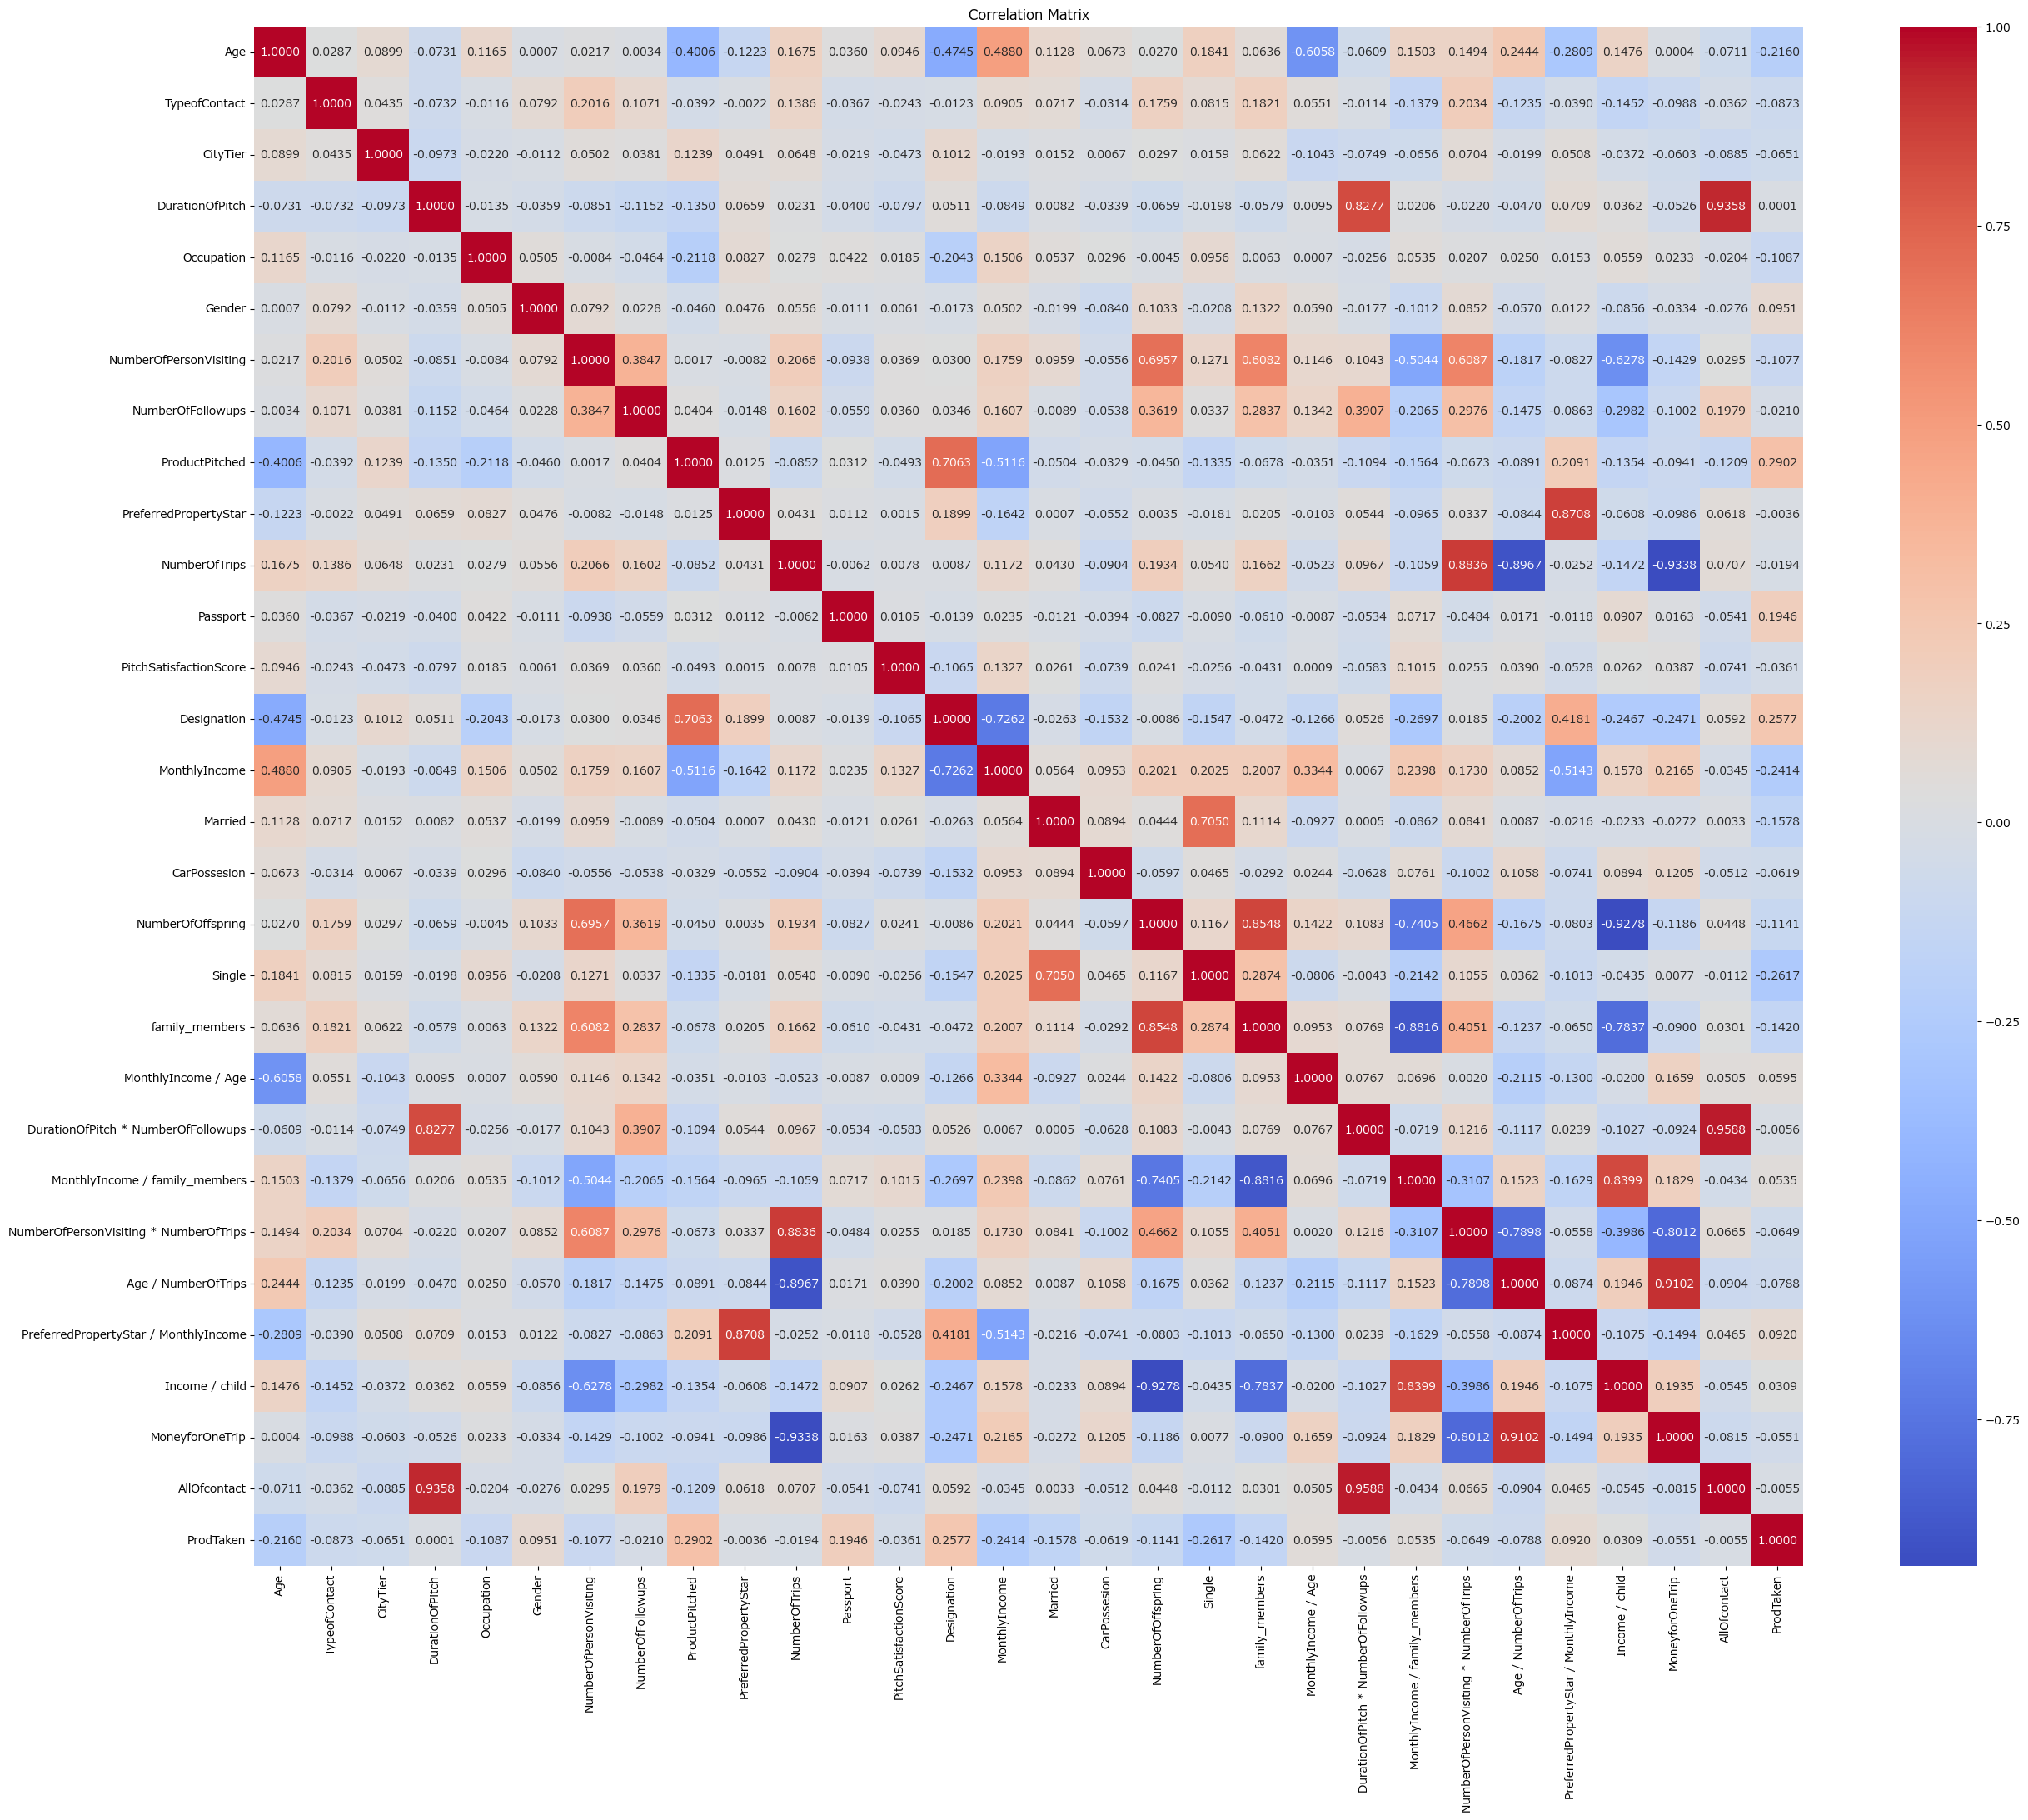

In [110]:
# 相関係数行列を計算
train1 = train1.dropna()
correlation_matrix = train1.corr(method='spearman')

plt.figure(figsize=(30, 24))
sns.heatmap(correlation_matrix, annot=True, fmt=".4f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

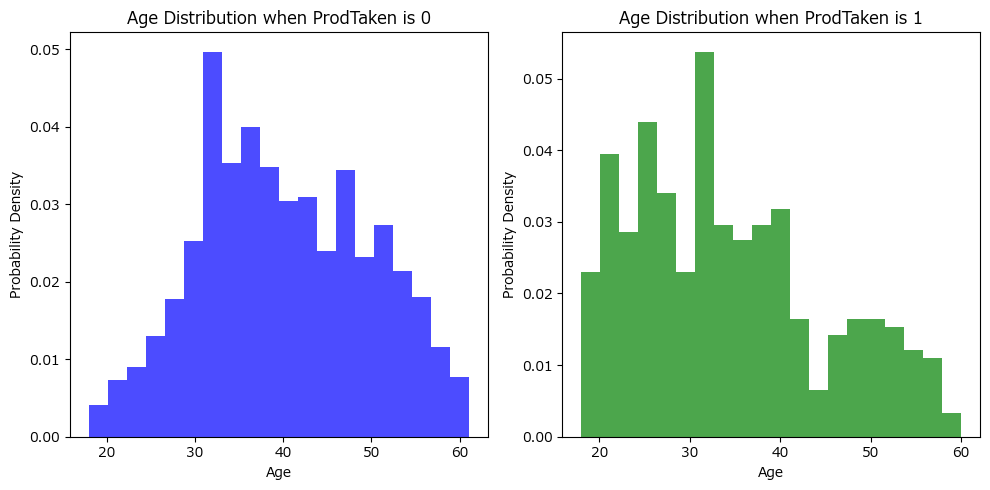

In [18]:
# プロットの設定
plt.figure(figsize=(10, 5))

# 'ProdTaken'が0の場合の'Age'のヒストグラム（確率密度で表示）
plt.subplot(1, 2, 1)
plt.hist(train1[train1['ProdTaken'] == 0]['Age'], bins=20, alpha=0.7, color='blue', density=True)
plt.title('Age Distribution when ProdTaken is 0')
plt.xlabel('Age')
plt.ylabel('Probability Density')

# 'ProdTaken'が1の場合の'Age'のヒストグラム（確率密度で表示）
plt.subplot(1, 2, 2)
plt.hist(train1[train1['ProdTaken'] == 1]['Age'], bins=20, alpha=0.7, color='green', density=True)
plt.title('Age Distribution when ProdTaken is 1')
plt.xlabel('Age')
plt.ylabel('Probability Density')

plt.tight_layout()
plt.show()

In [59]:
def frequency_plot(feature):
    age_prod_taken_rate = train1.groupby(feature)['ProdTaken'].mean()

    age_counts_tr = train1[feature].value_counts().sort_index()
    age_counts_te = test1[feature].value_counts().sort_index()

    plt.figure(figsize=(14, 12))

    plt.subplot(3, 1, 1)
    age_prod_taken_rate.plot(kind='bar', color='skyblue', alpha=0.7)
    plt.title(f'Percentage of ProdTaken = 1 by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Percentage')
    plt.grid(True)

    plt.subplot(3, 1, 2)
    age_counts_tr.plot(kind='bar', color='lightgreen', alpha=0.7)
    plt.title(f'Number of People by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    age_counts_te.plot(kind='bar', color='lightgreen', alpha=0.7)
    plt.title(f'Number of People by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

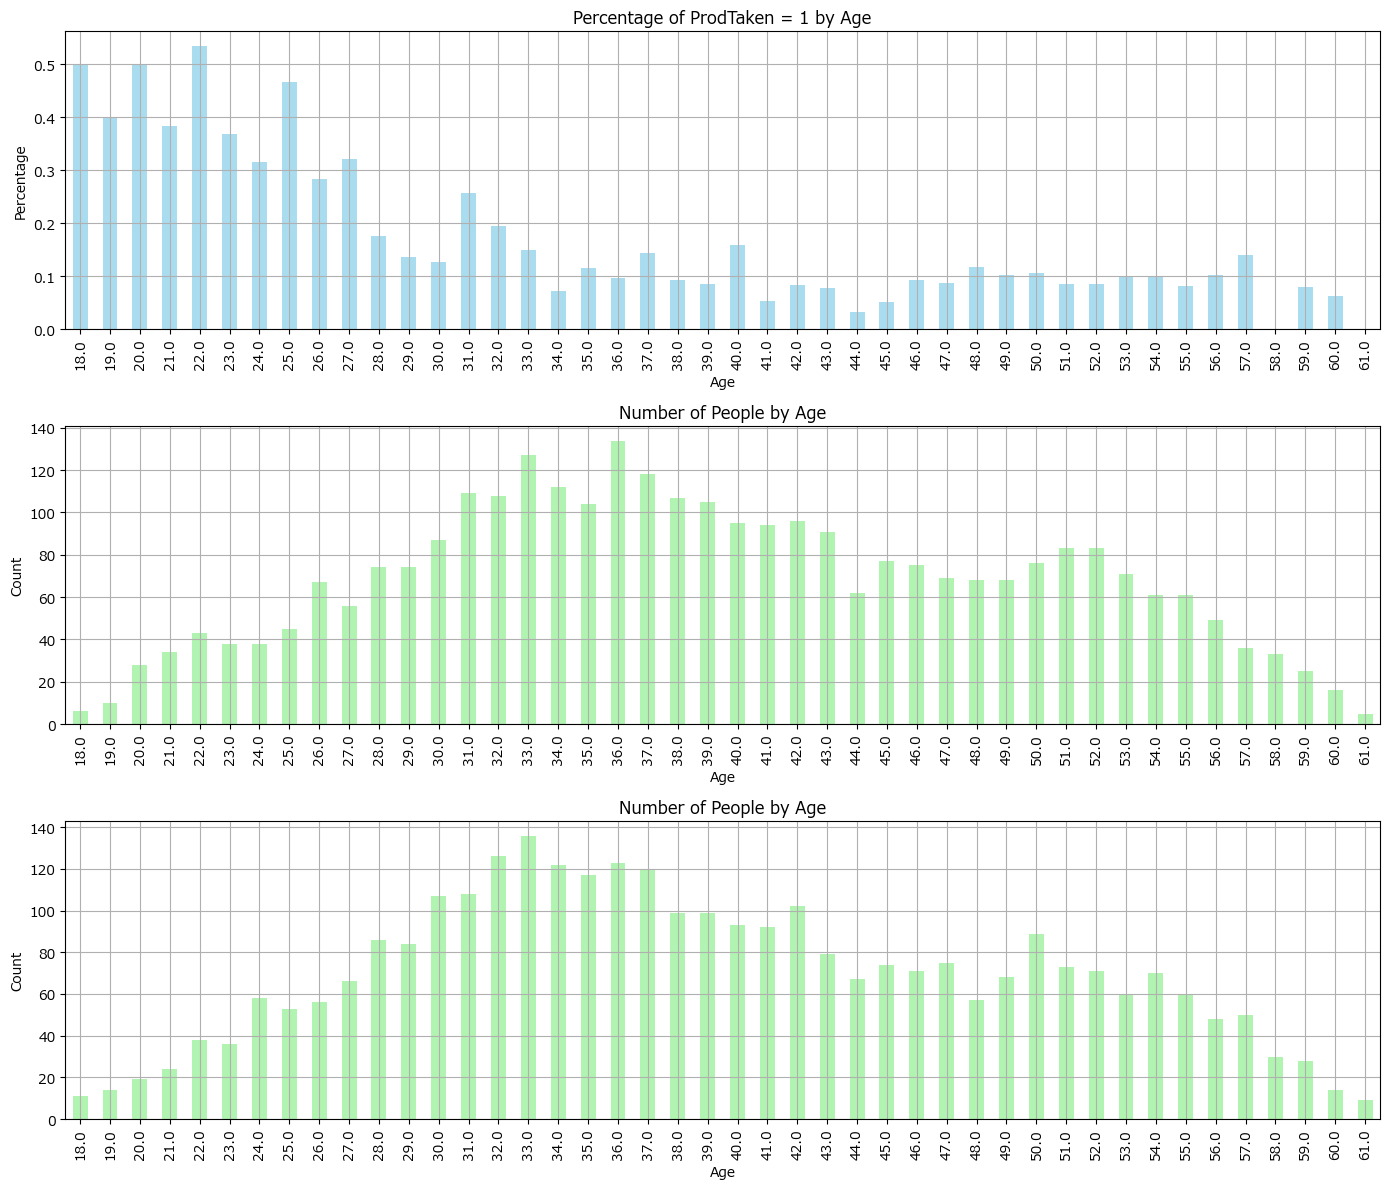

In [60]:
# Age
frequency_plot('Age')

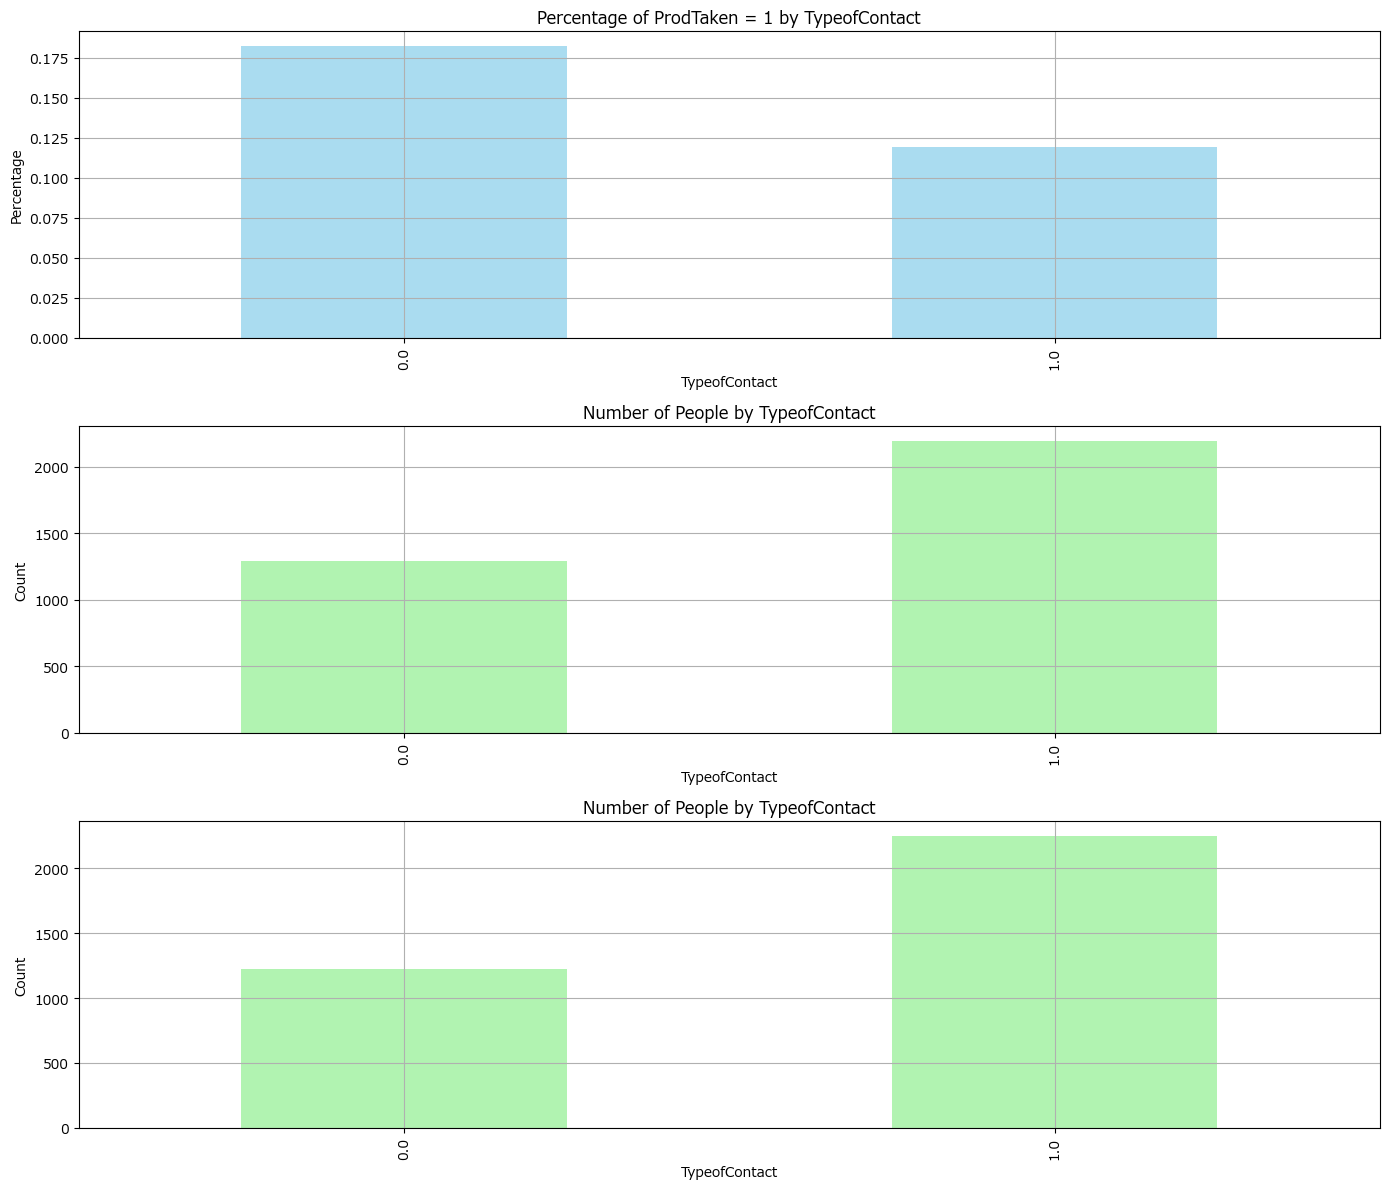

In [61]:
# TypeofContact
frequency_plot('TypeofContact')

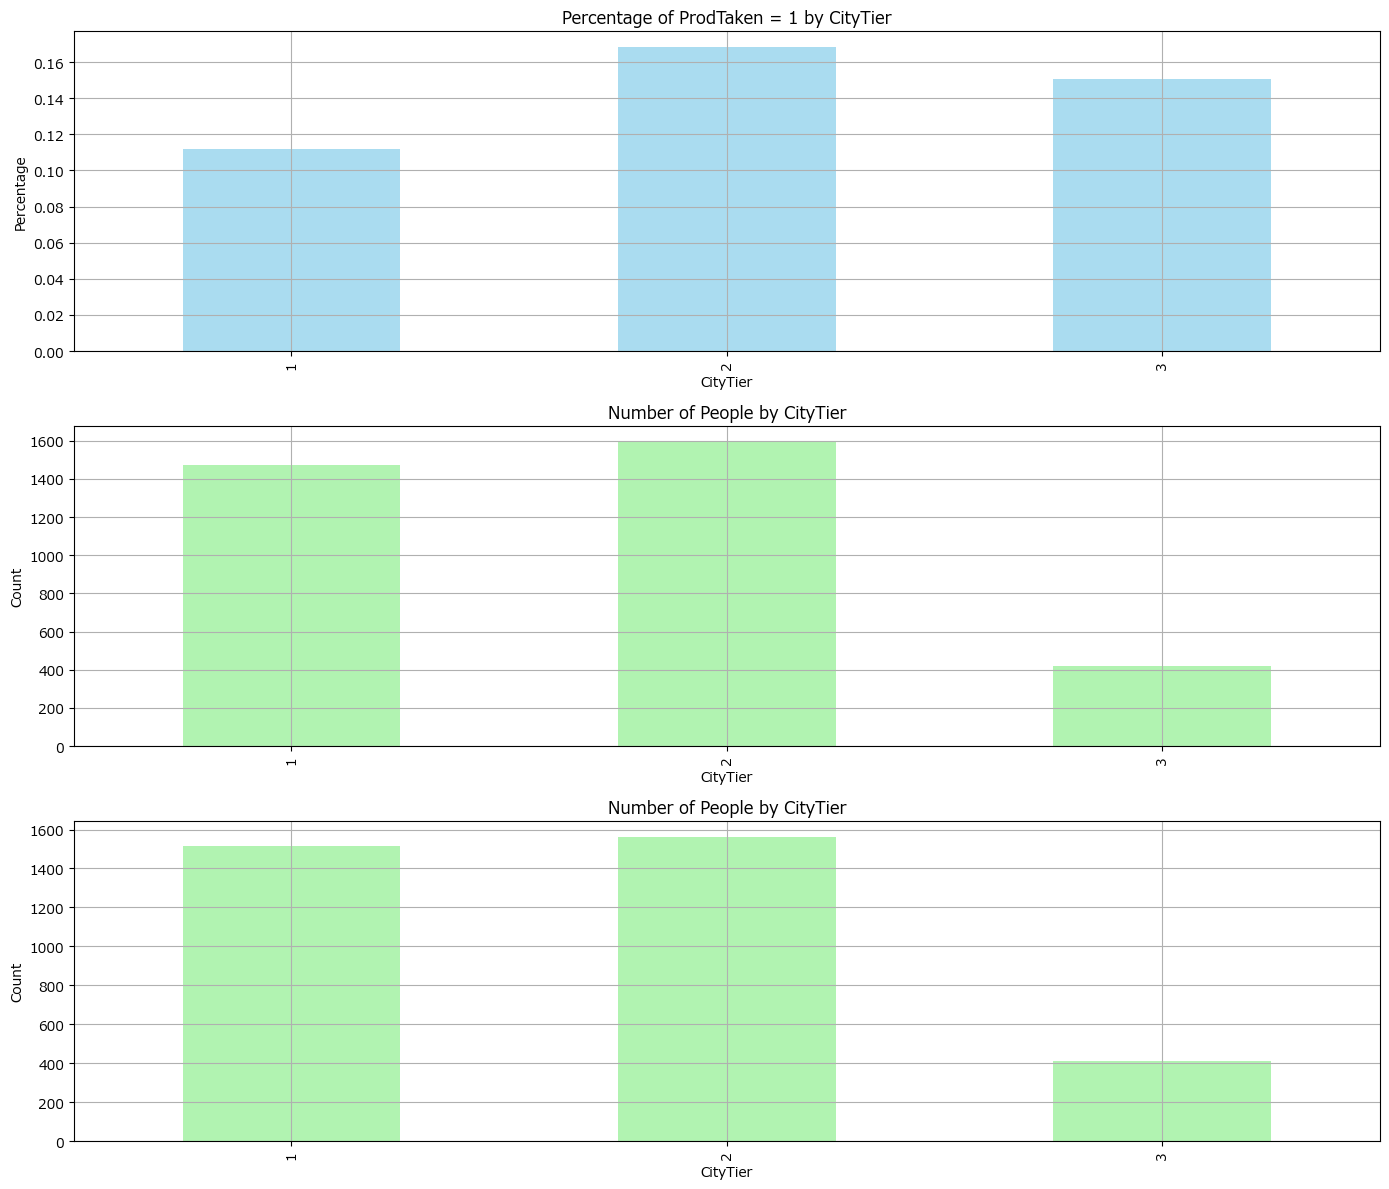

In [62]:
# 'CityTier'
frequency_plot('CityTier')

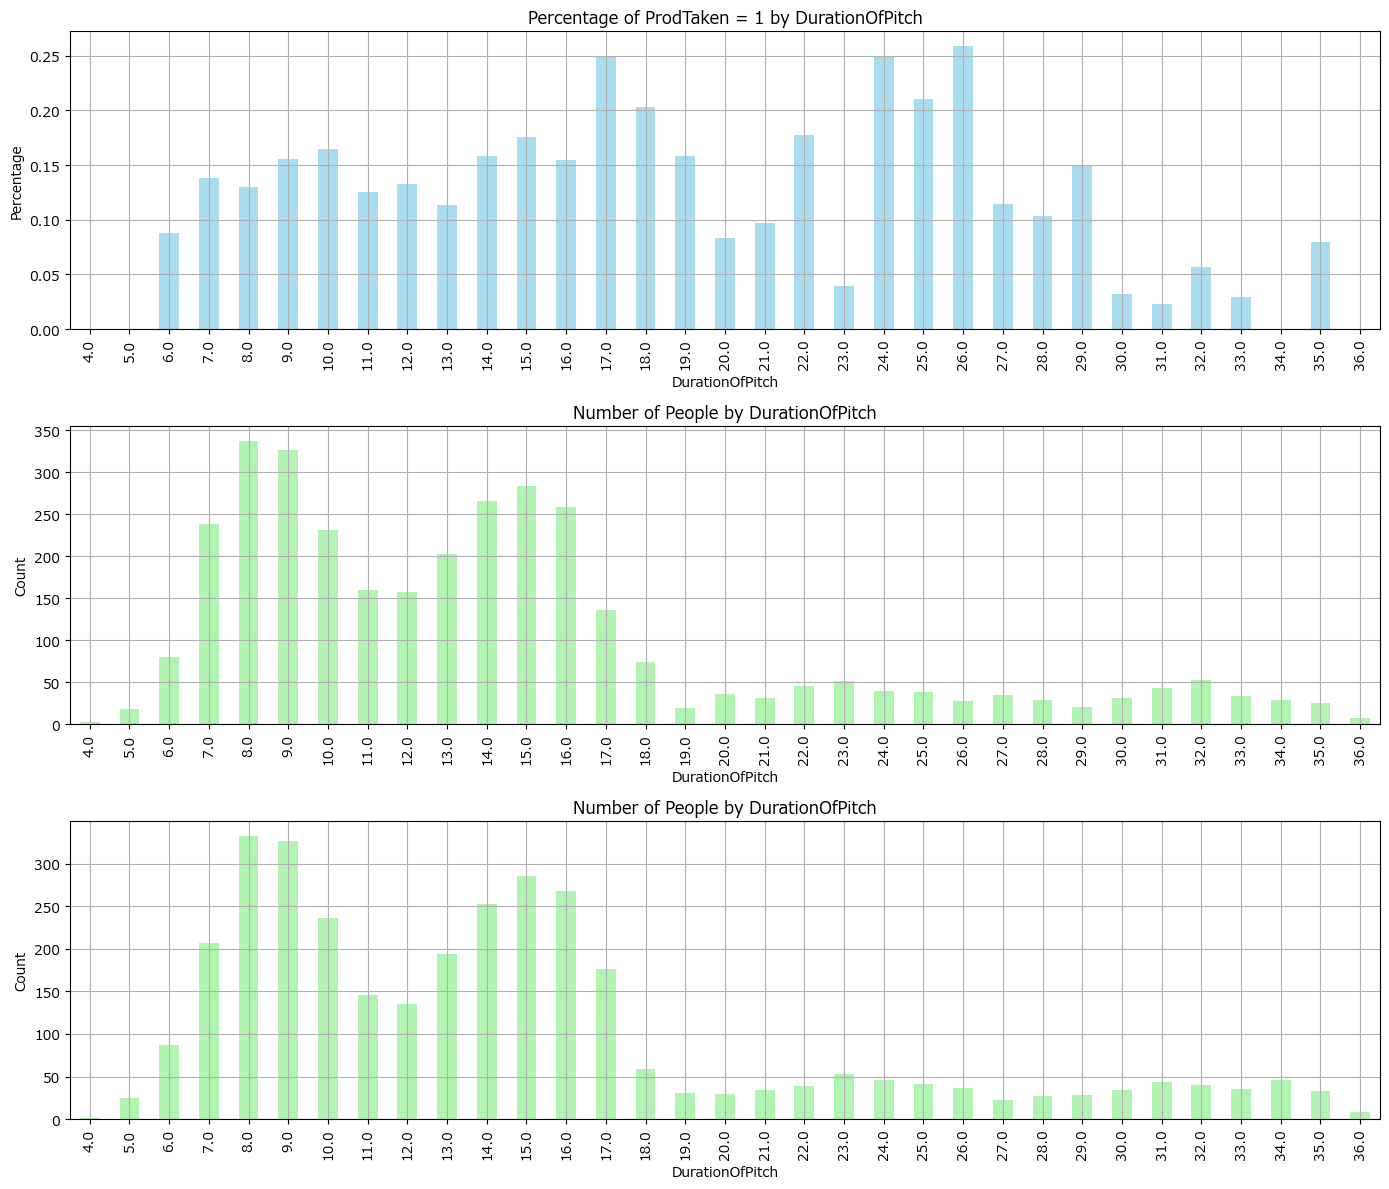

In [63]:
# DurationOfPitch
frequency_plot('DurationOfPitch')

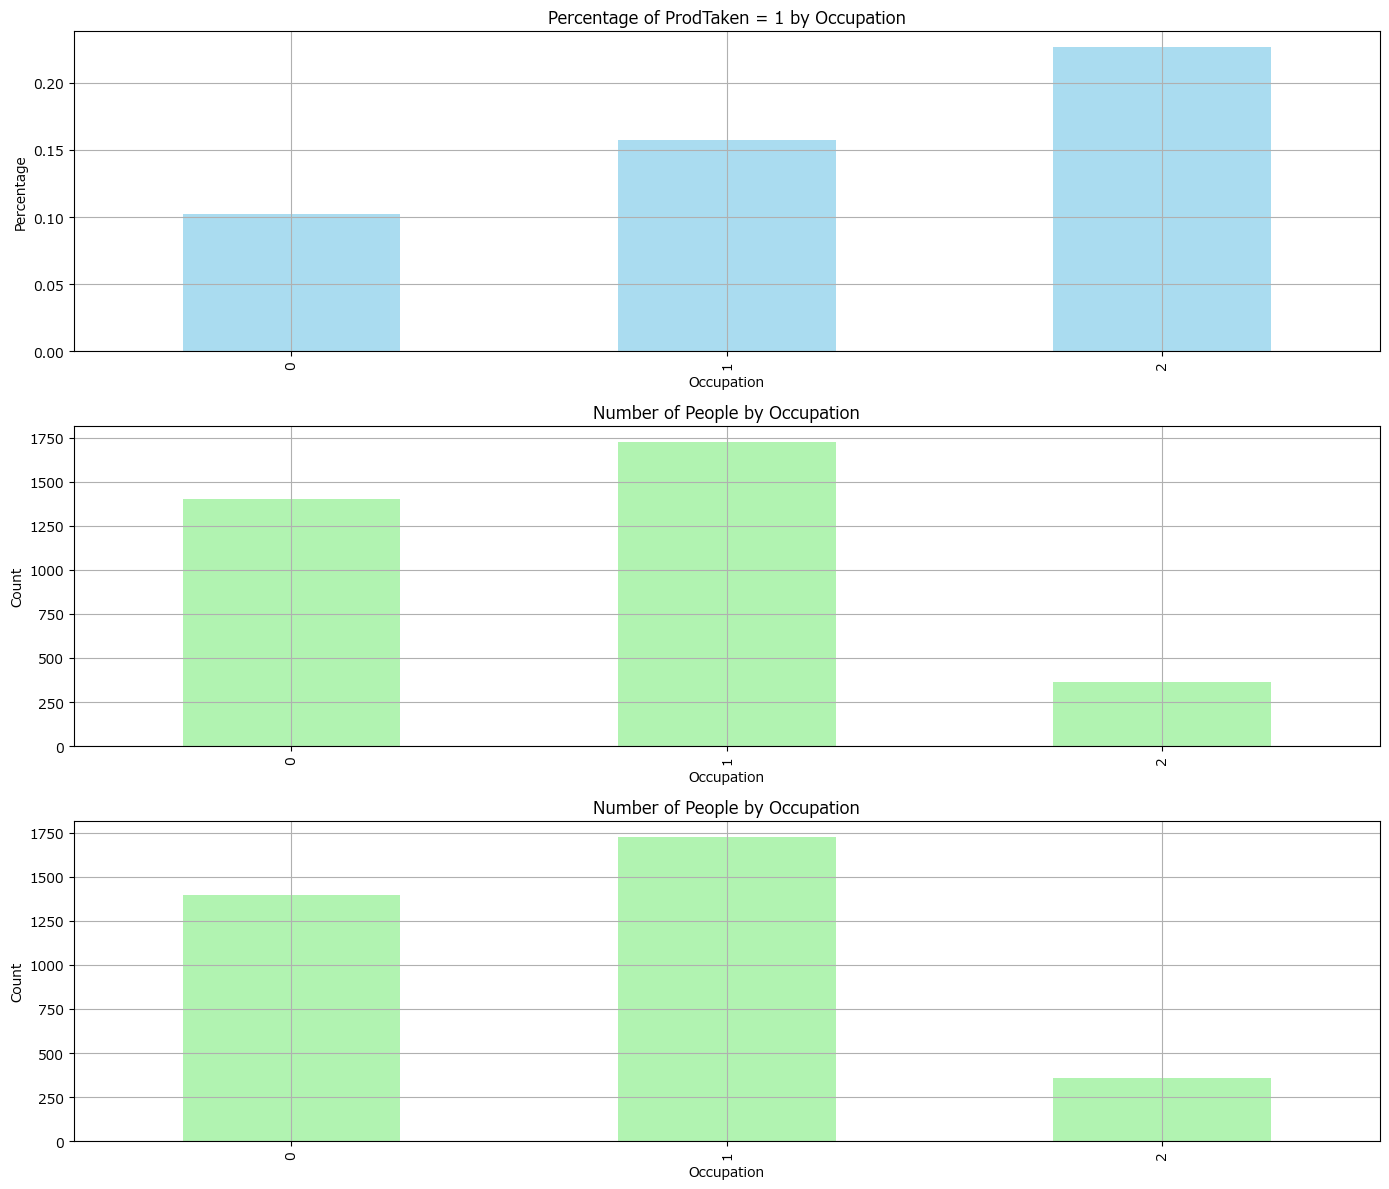

In [64]:
# Occupation
frequency_plot('Occupation')

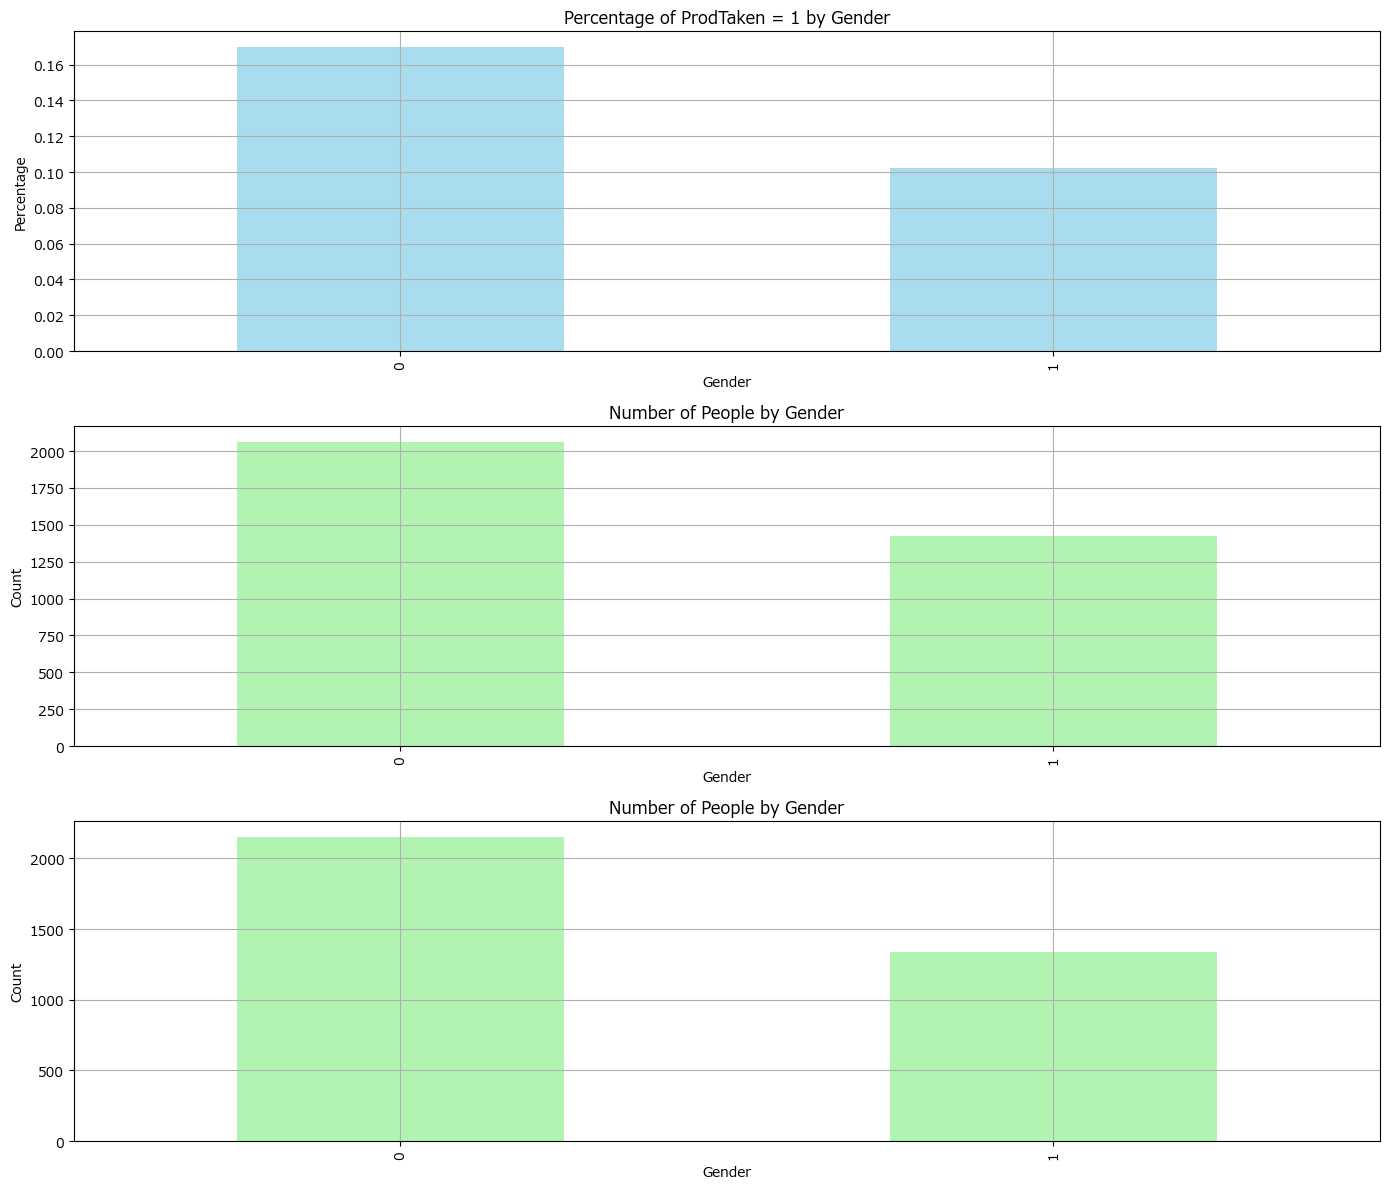

In [65]:
# Gender
frequency_plot('Gender')

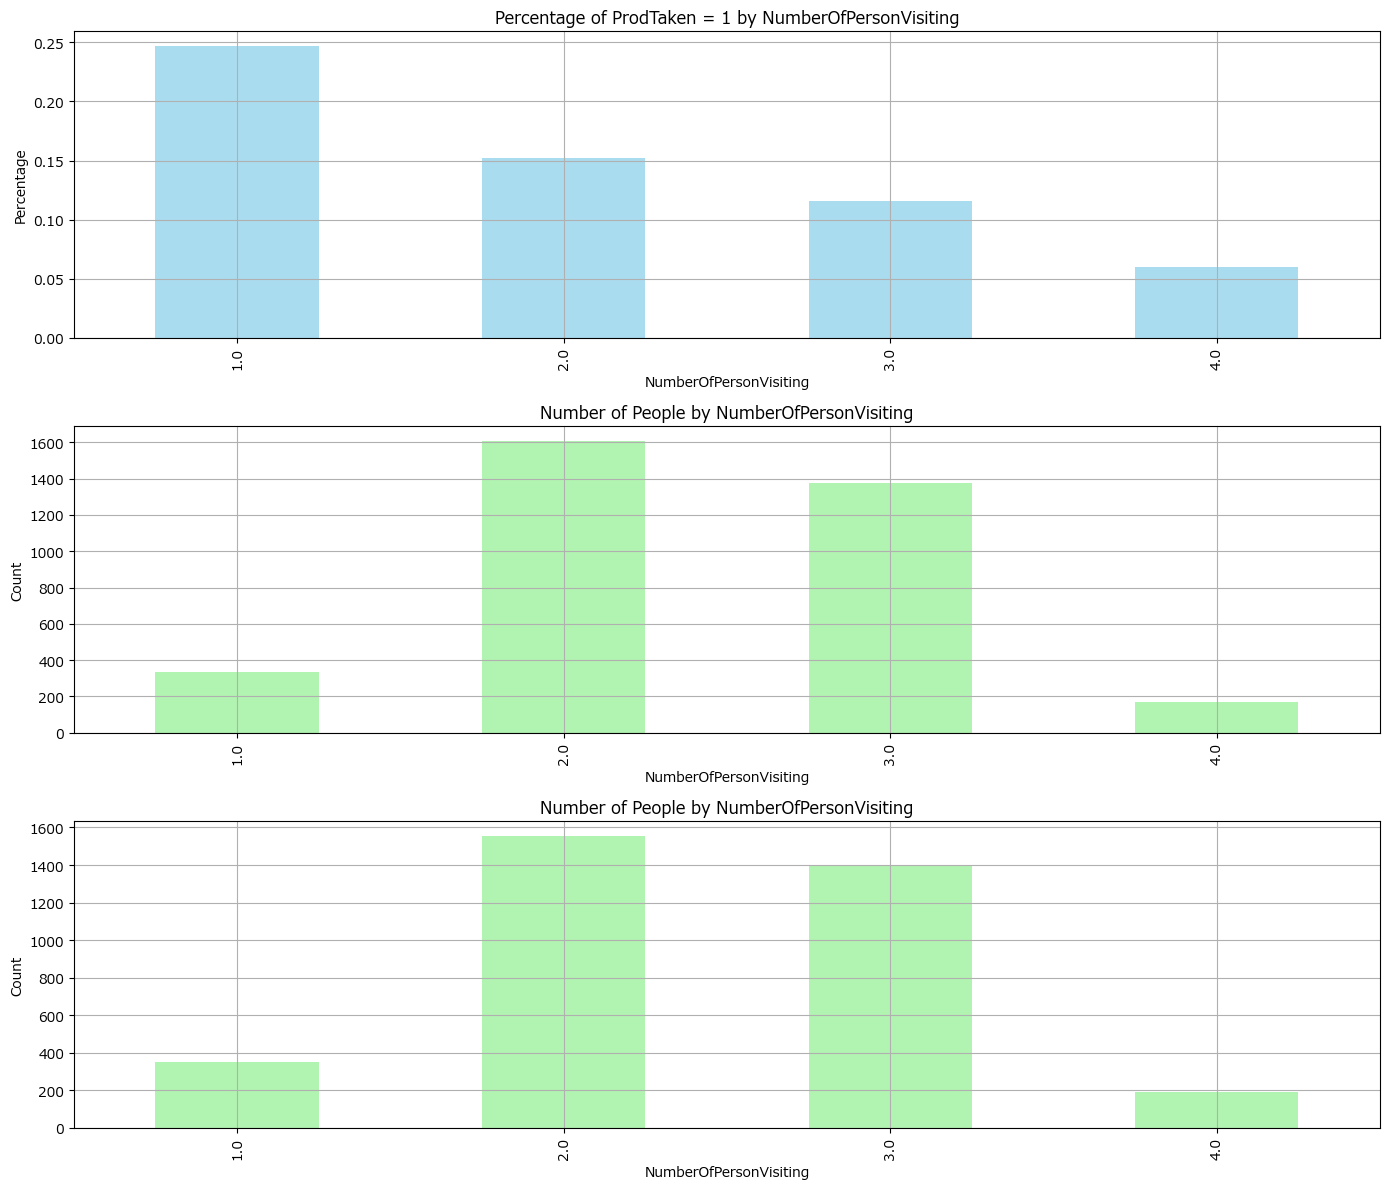

In [66]:
# NumberOfPersonVisiting
frequency_plot('NumberOfPersonVisiting')

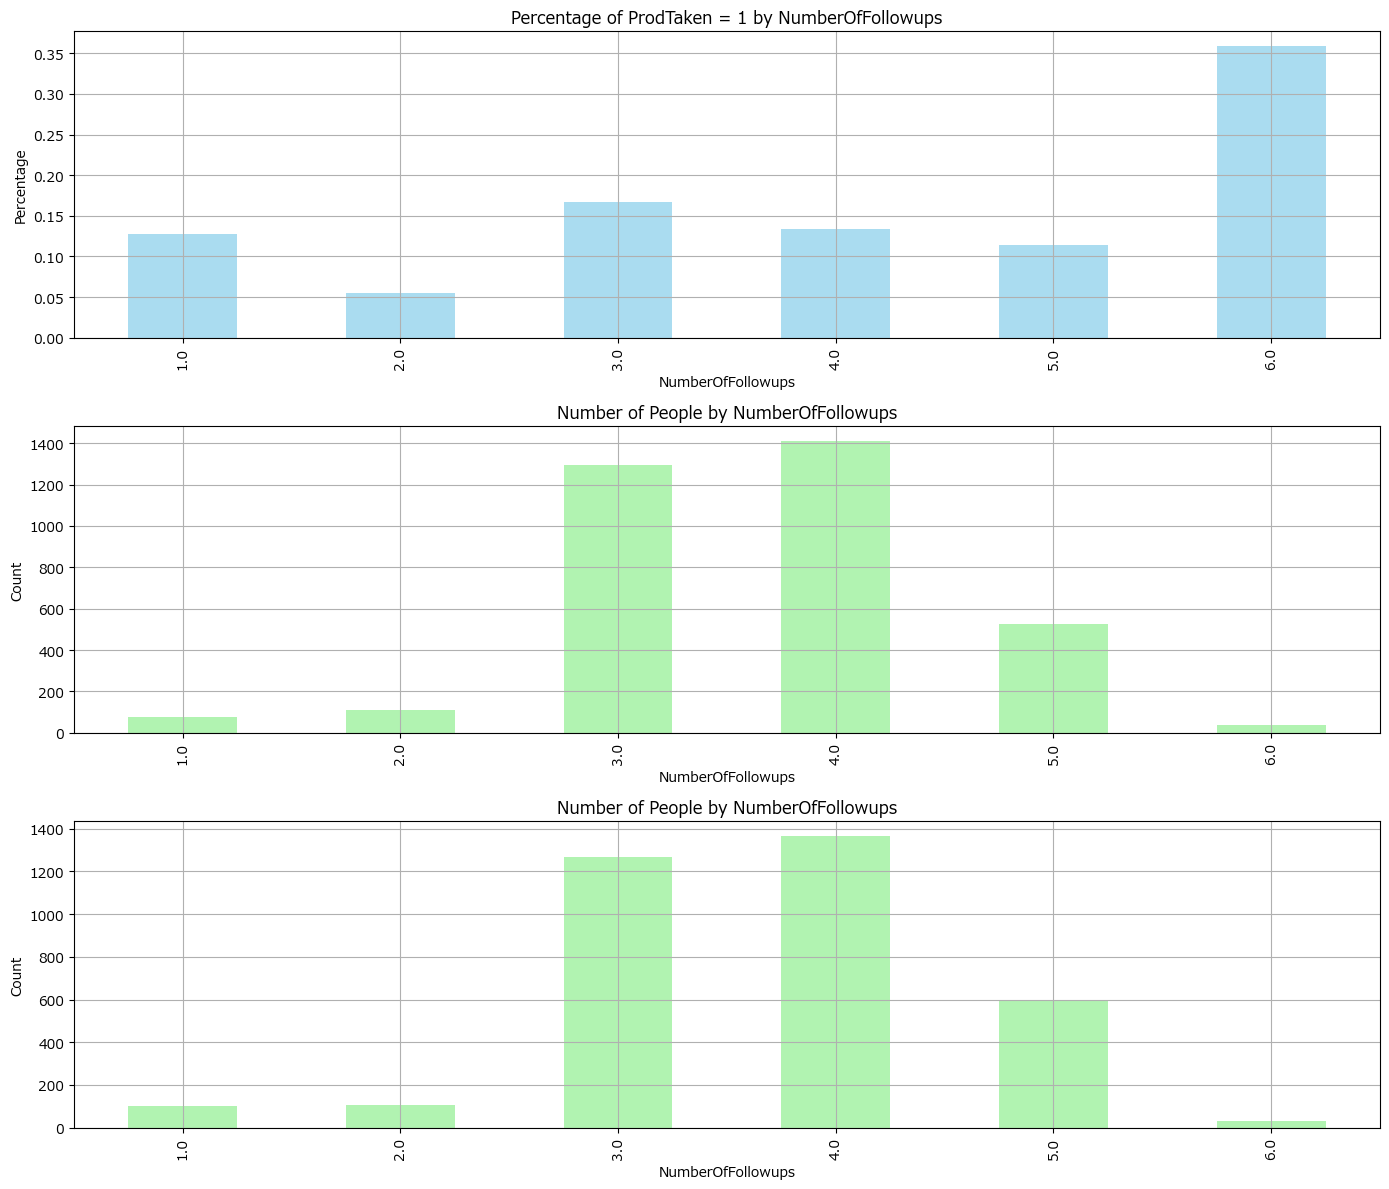

In [67]:
# NumberOfFollowups
frequency_plot('NumberOfFollowups')

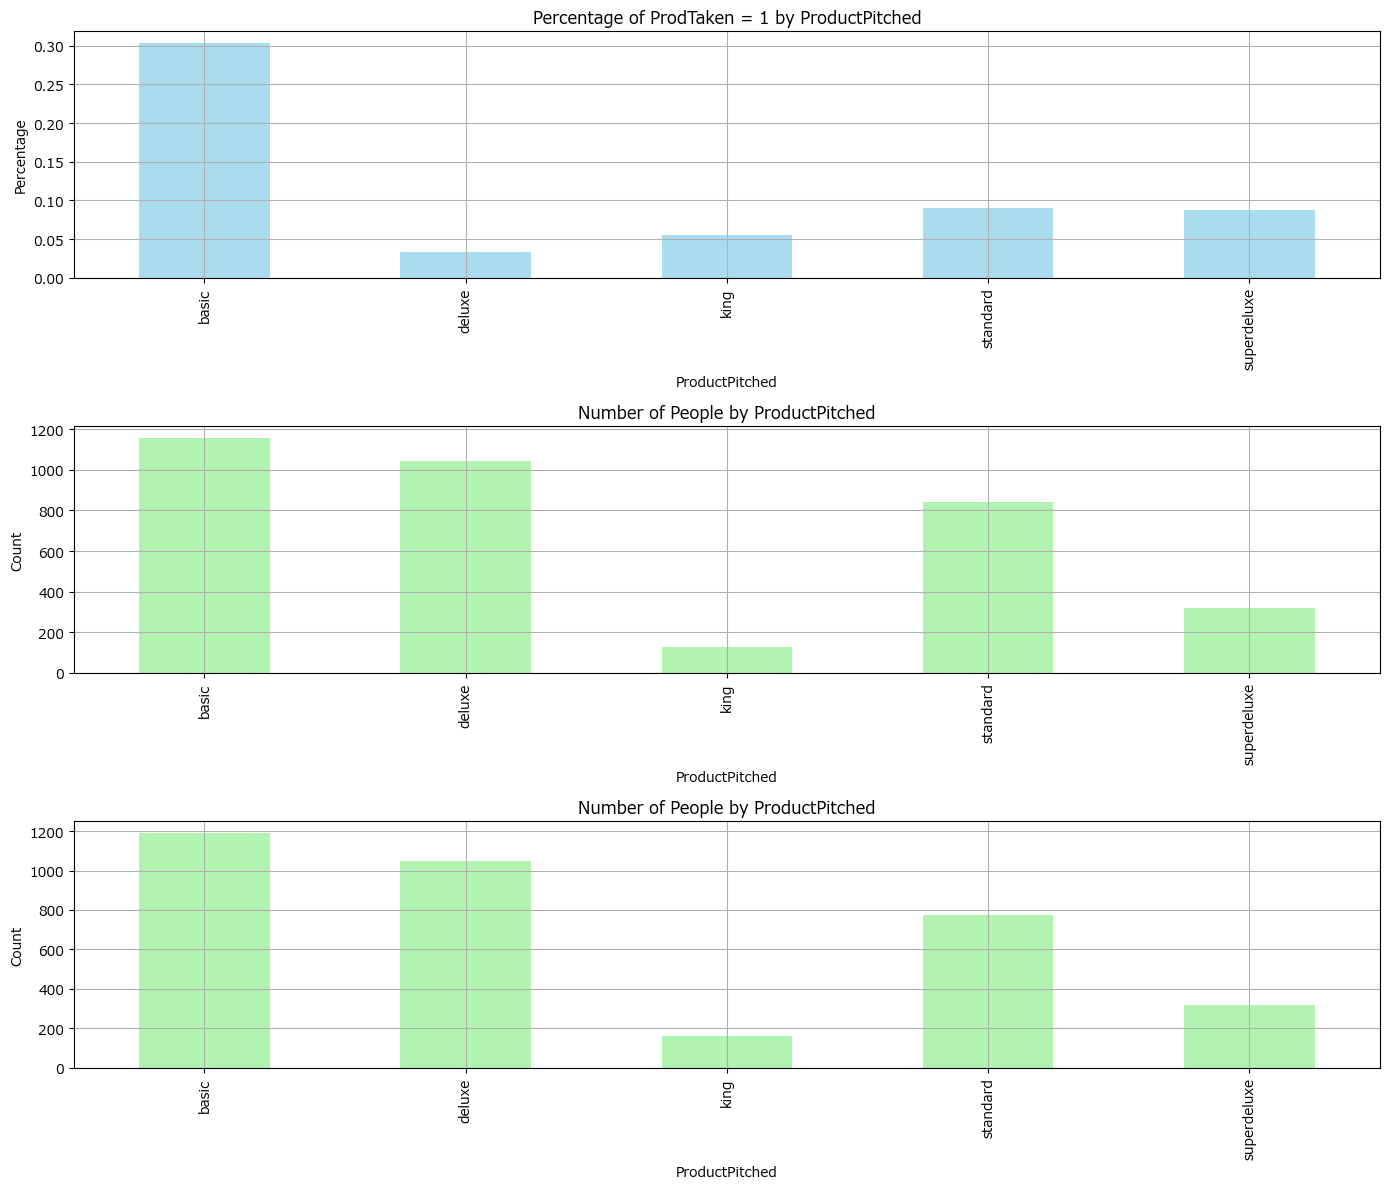

In [68]:
# ProductPitched
frequency_plot('ProductPitched')

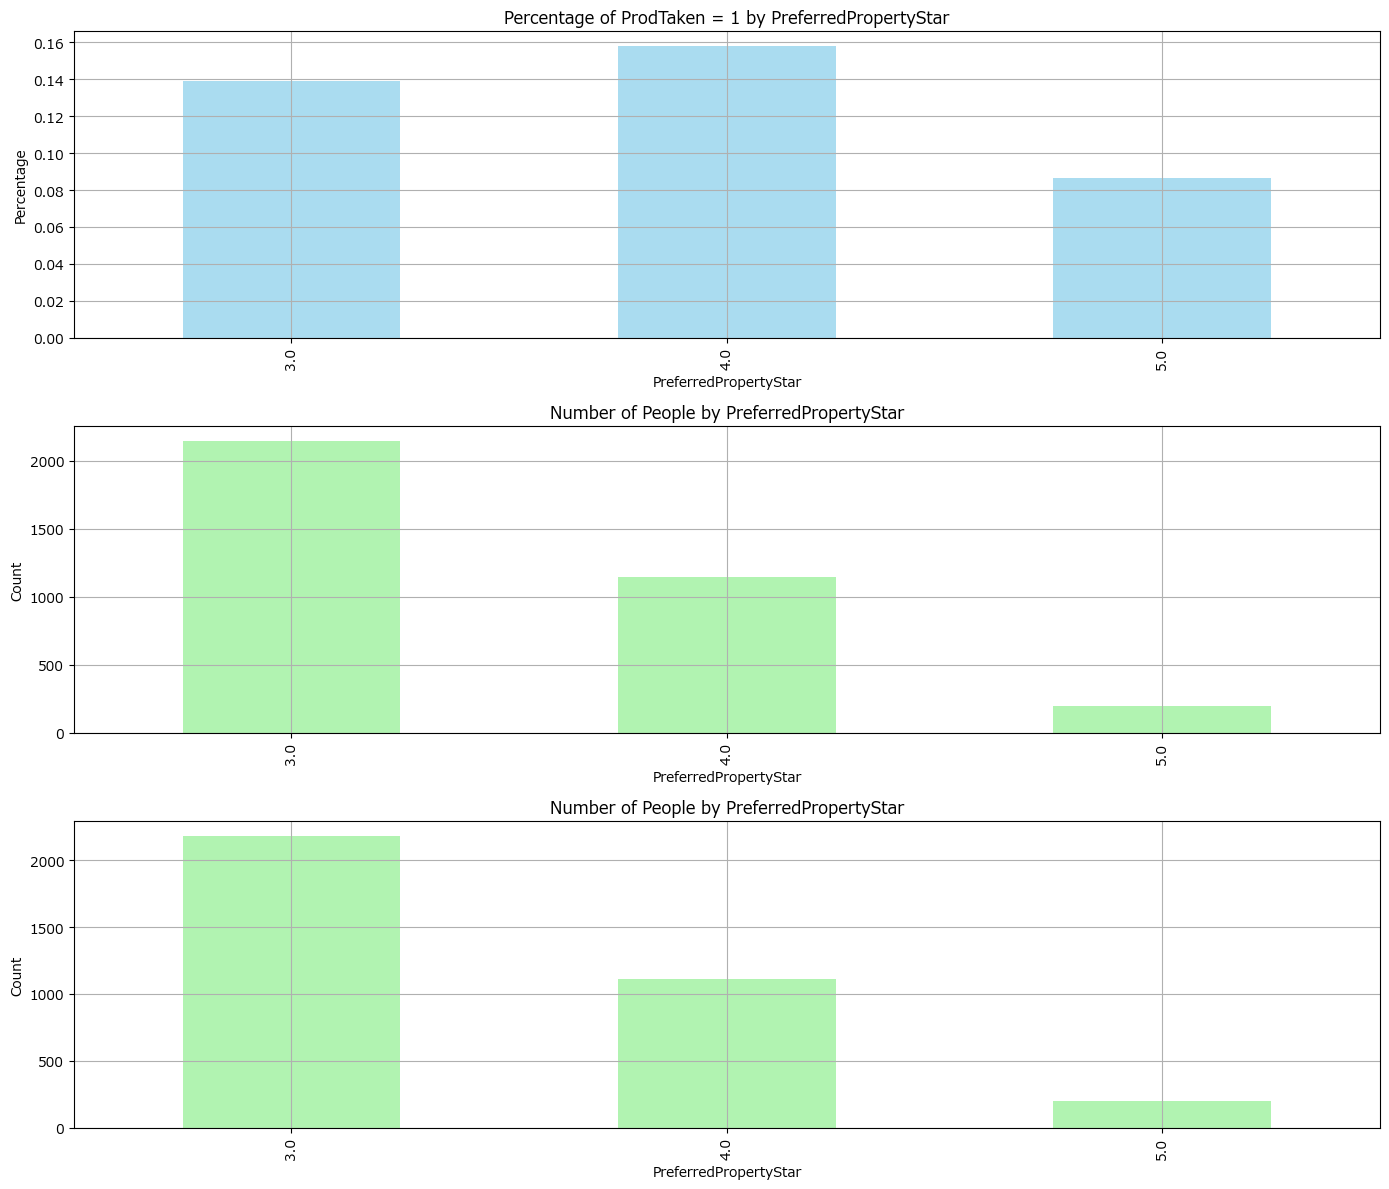

In [69]:
# PreferredPropertyStar
frequency_plot('PreferredPropertyStar')

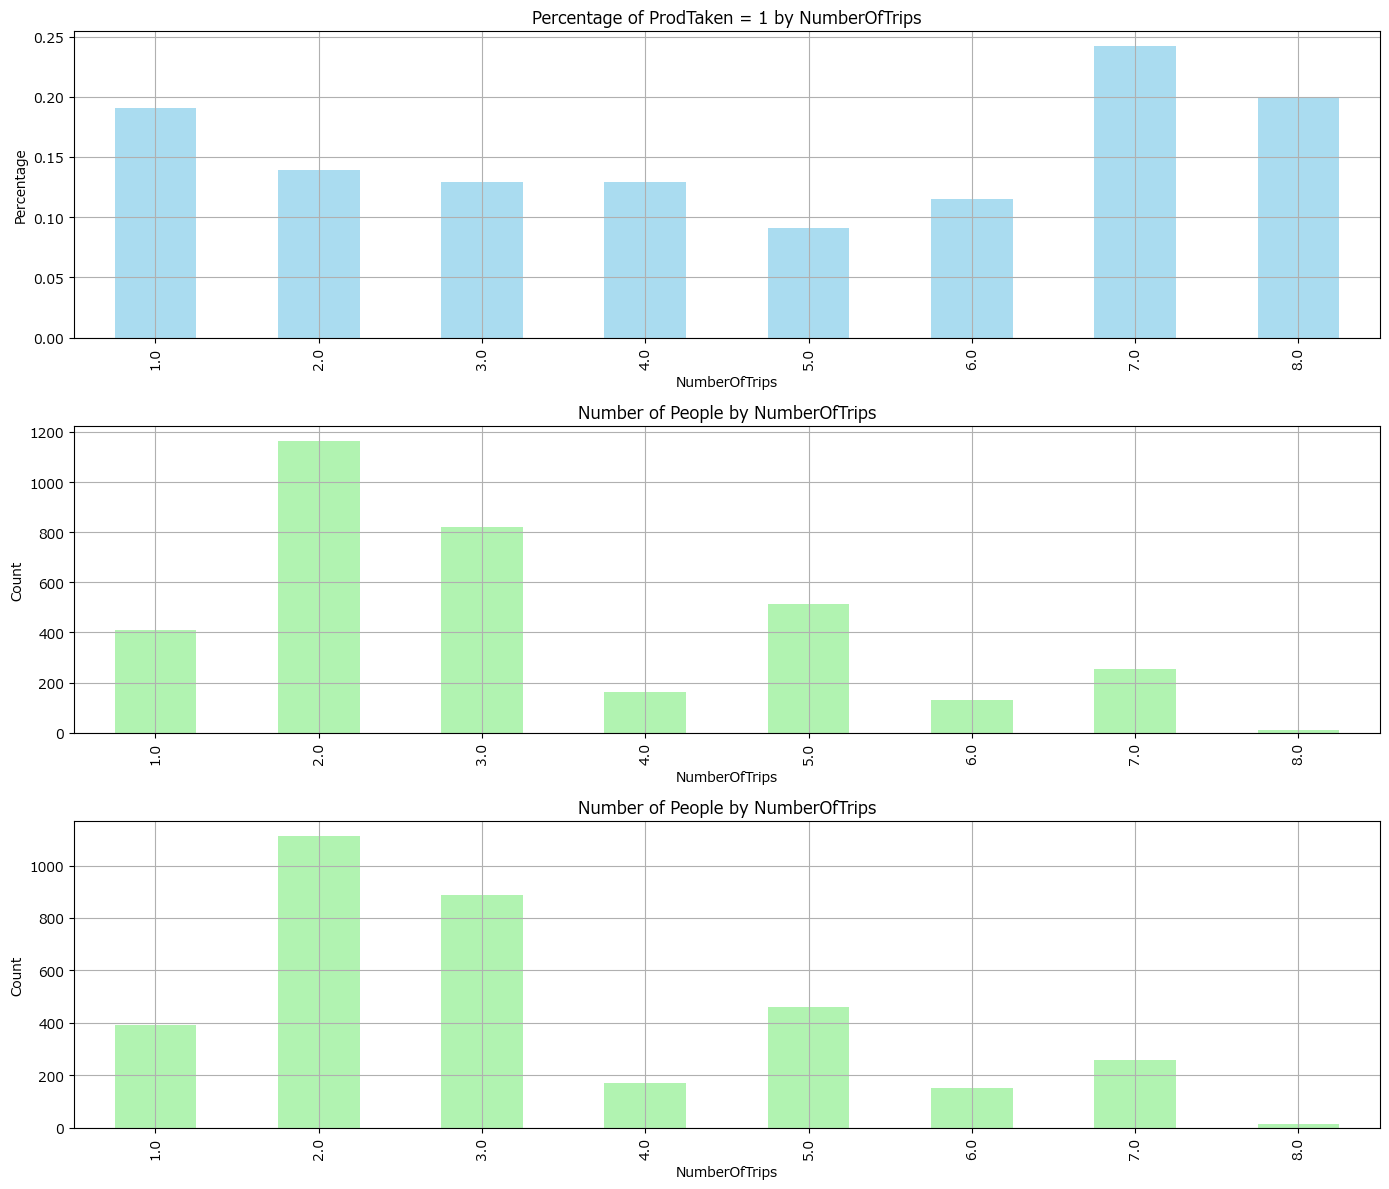

In [70]:
# NumberOfTrips
frequency_plot('NumberOfTrips')

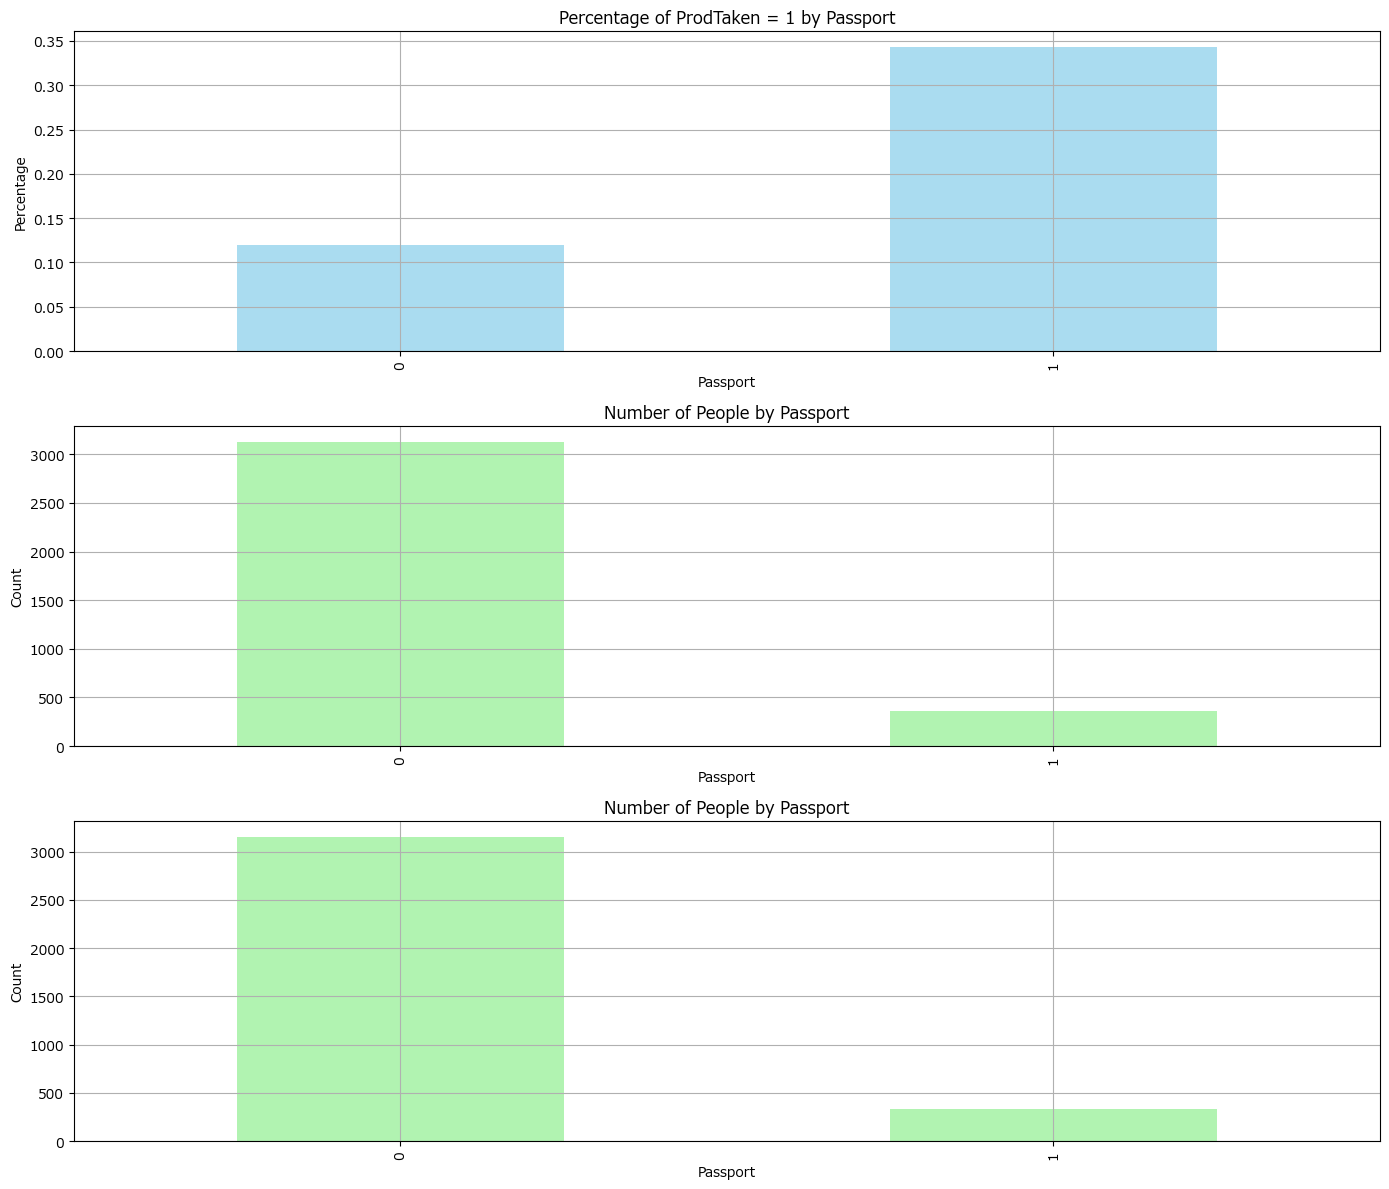

In [71]:
# Passport
frequency_plot('Passport')

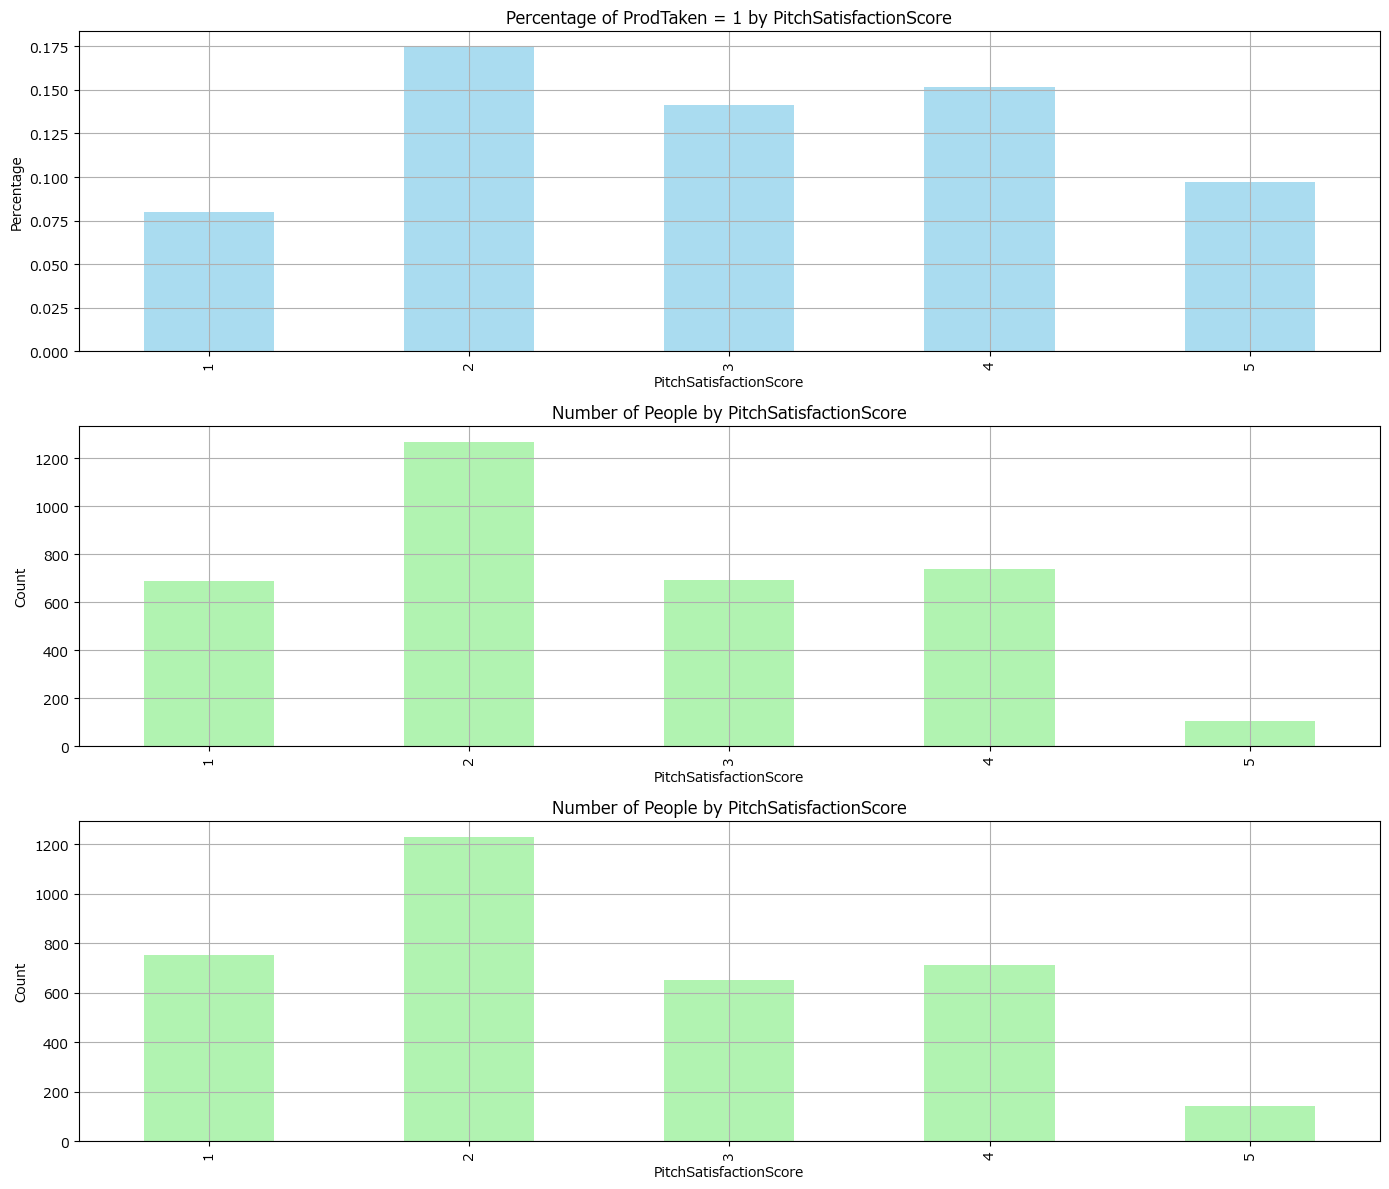

In [72]:
# PitchSatisfactionScore
frequency_plot('PitchSatisfactionScore')

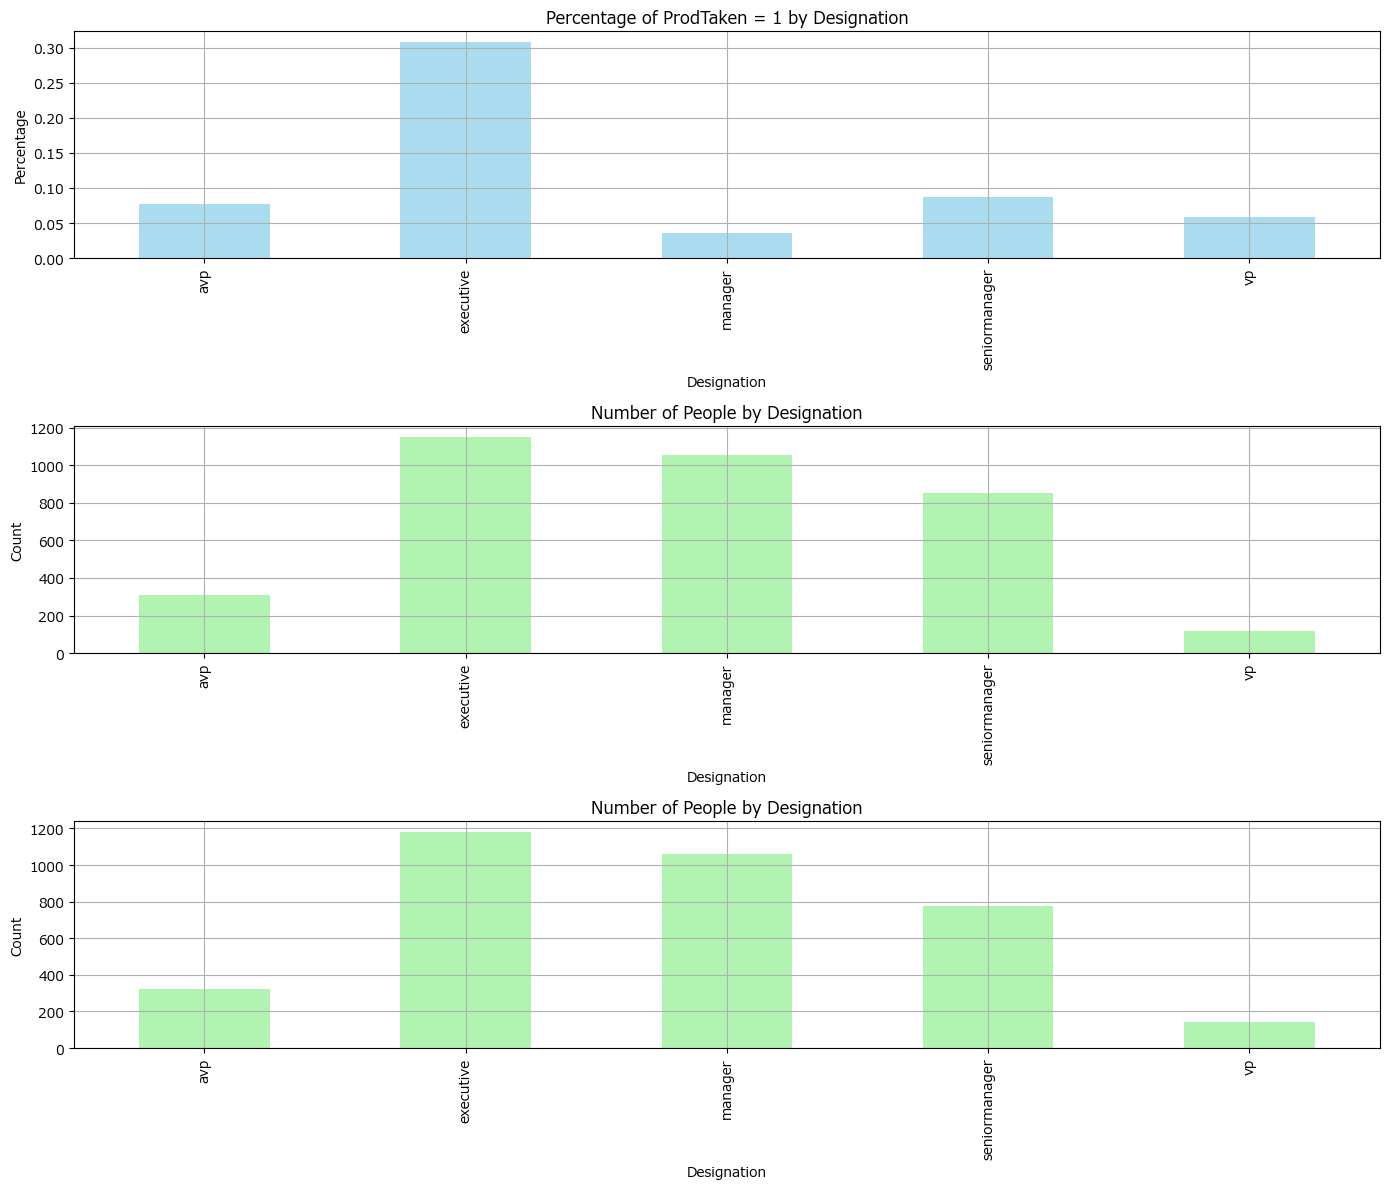

In [73]:
# Designation
frequency_plot('Designation')

C:\Users\yutak\AppData\Local\Temp\ipykernel_298812\4228350217.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_prod_taken_rate = train1.groupby('IncomeBin')['ProdTaken'].mean()


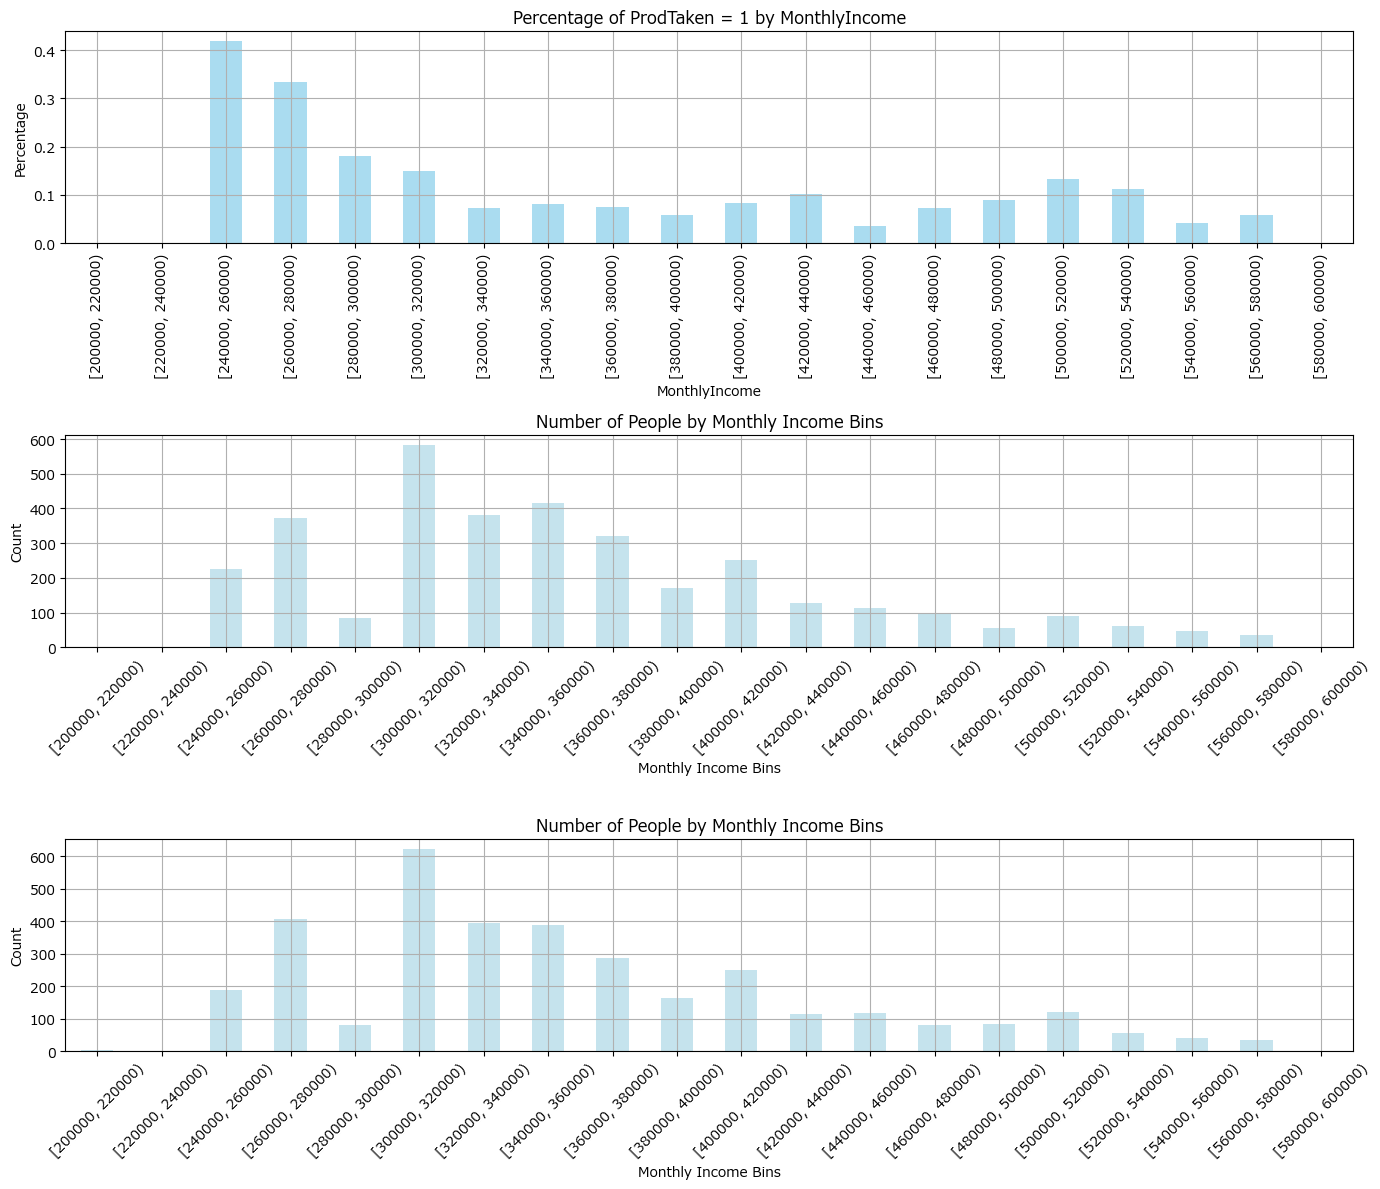

In [77]:
# MonthlyIncome
# 'MonthlyIncome' の値を階級に分ける
# ここでは例として100000円ごとの階級を作成
bins = range(int(train1['MonthlyIncome'].min()), int(train1['MonthlyIncome'].max()) + 20000, 20000)
train1['IncomeBin'] = pd.cut(train1['MonthlyIncome'], bins=bins, right=False)
test1['IncomeBin'] = pd.cut(test1['MonthlyIncome'], bins=bins, right=False)

# 階級ごとに 'ProdTaken' が 1 の割合を計算
income_prod_taken_rate = train1.groupby('IncomeBin')['ProdTaken'].mean()
# 階級ごとの人数をカウント
income_counts_tr = train1['IncomeBin'].value_counts().sort_index()
income_counts_te = test1['IncomeBin'].value_counts().sort_index()

# プロットの設定
plt.figure(figsize=(14, 12))

# 上のサブプロット：ProdTaken = 1 の割合
plt.subplot(3, 1, 1)  # 2行1列のグリッドの最初の位置
income_prod_taken_rate.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Percentage of ProdTaken = 1 by MonthlyIncome')
plt.xlabel('MonthlyIncome')
plt.ylabel('Percentage')
plt.grid(True)

# 下のサブプロット：階級ごとの収入の人数
plt.subplot(3, 1, 2)  # 2行1列のグリッドの2番目の位置
income_counts_tr.plot(kind='bar', color='lightblue', alpha=0.7)
plt.title('Number of People by Monthly Income Bins')
plt.xlabel('Monthly Income Bins')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(3, 1, 3)  # 2行1列のグリッドの2番目の位置
income_counts_te.plot(kind='bar', color='lightblue', alpha=0.7)
plt.title('Number of People by Monthly Income Bins')
plt.xlabel('Monthly Income Bins')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)


plt.tight_layout()
plt.show()

train1 = train1.drop(['IncomeBin'],axis=1)

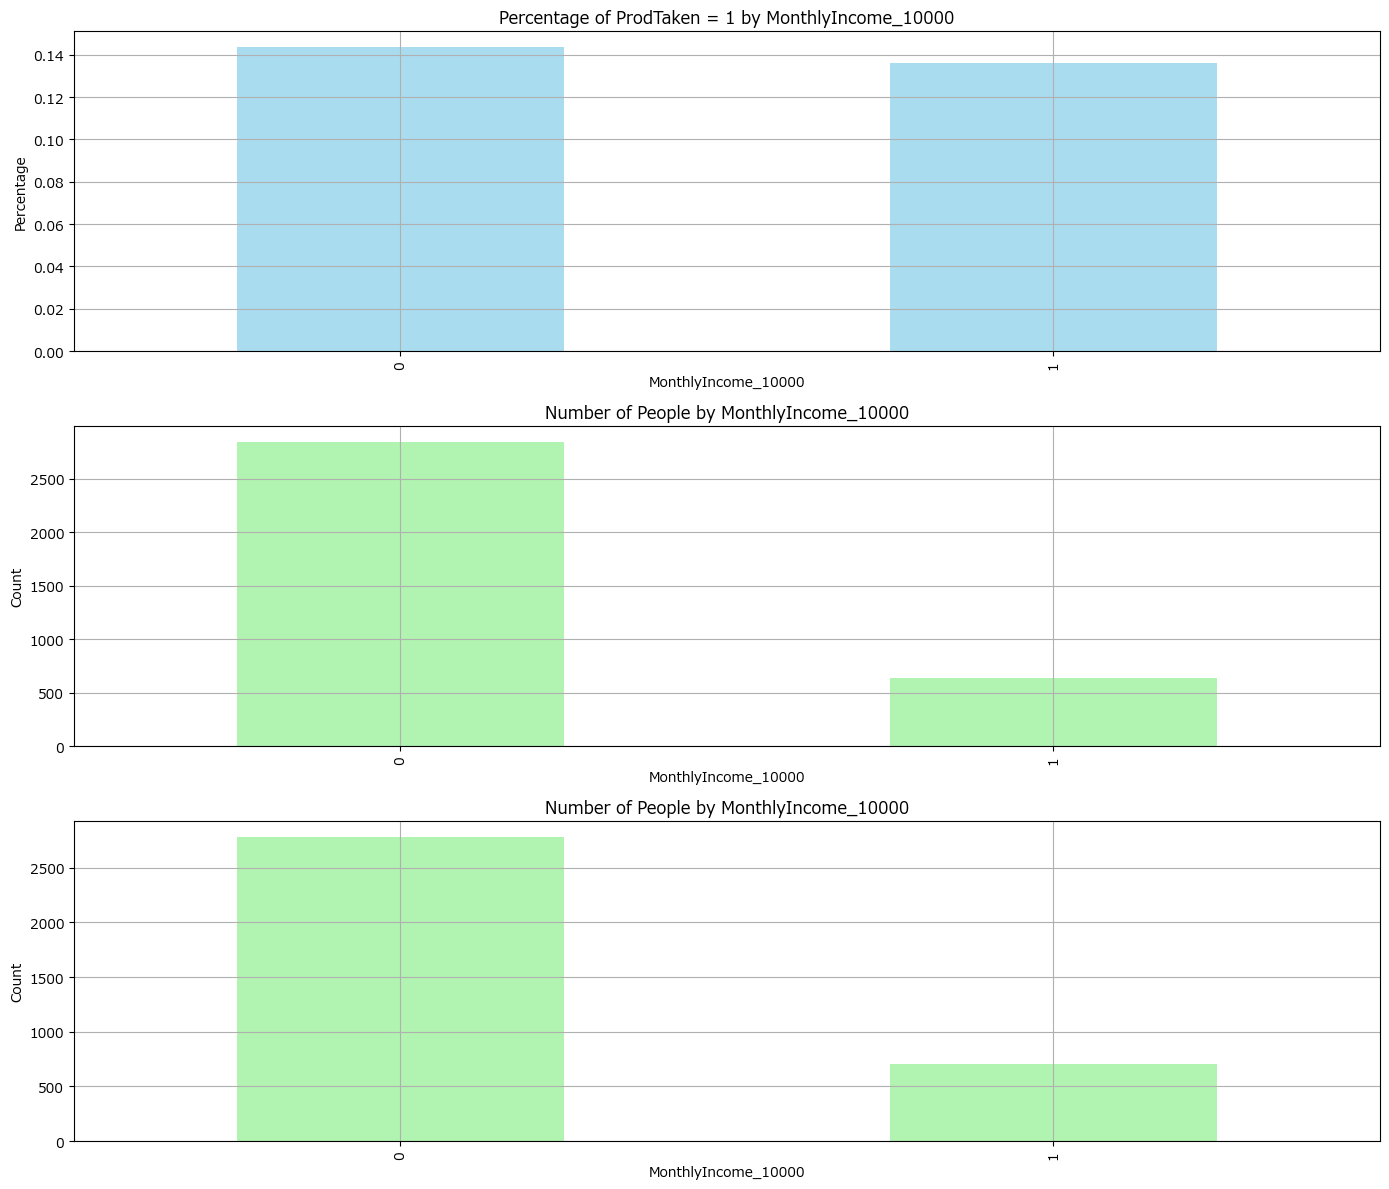

In [91]:
frequency_plot('MonthlyIncome_10000')

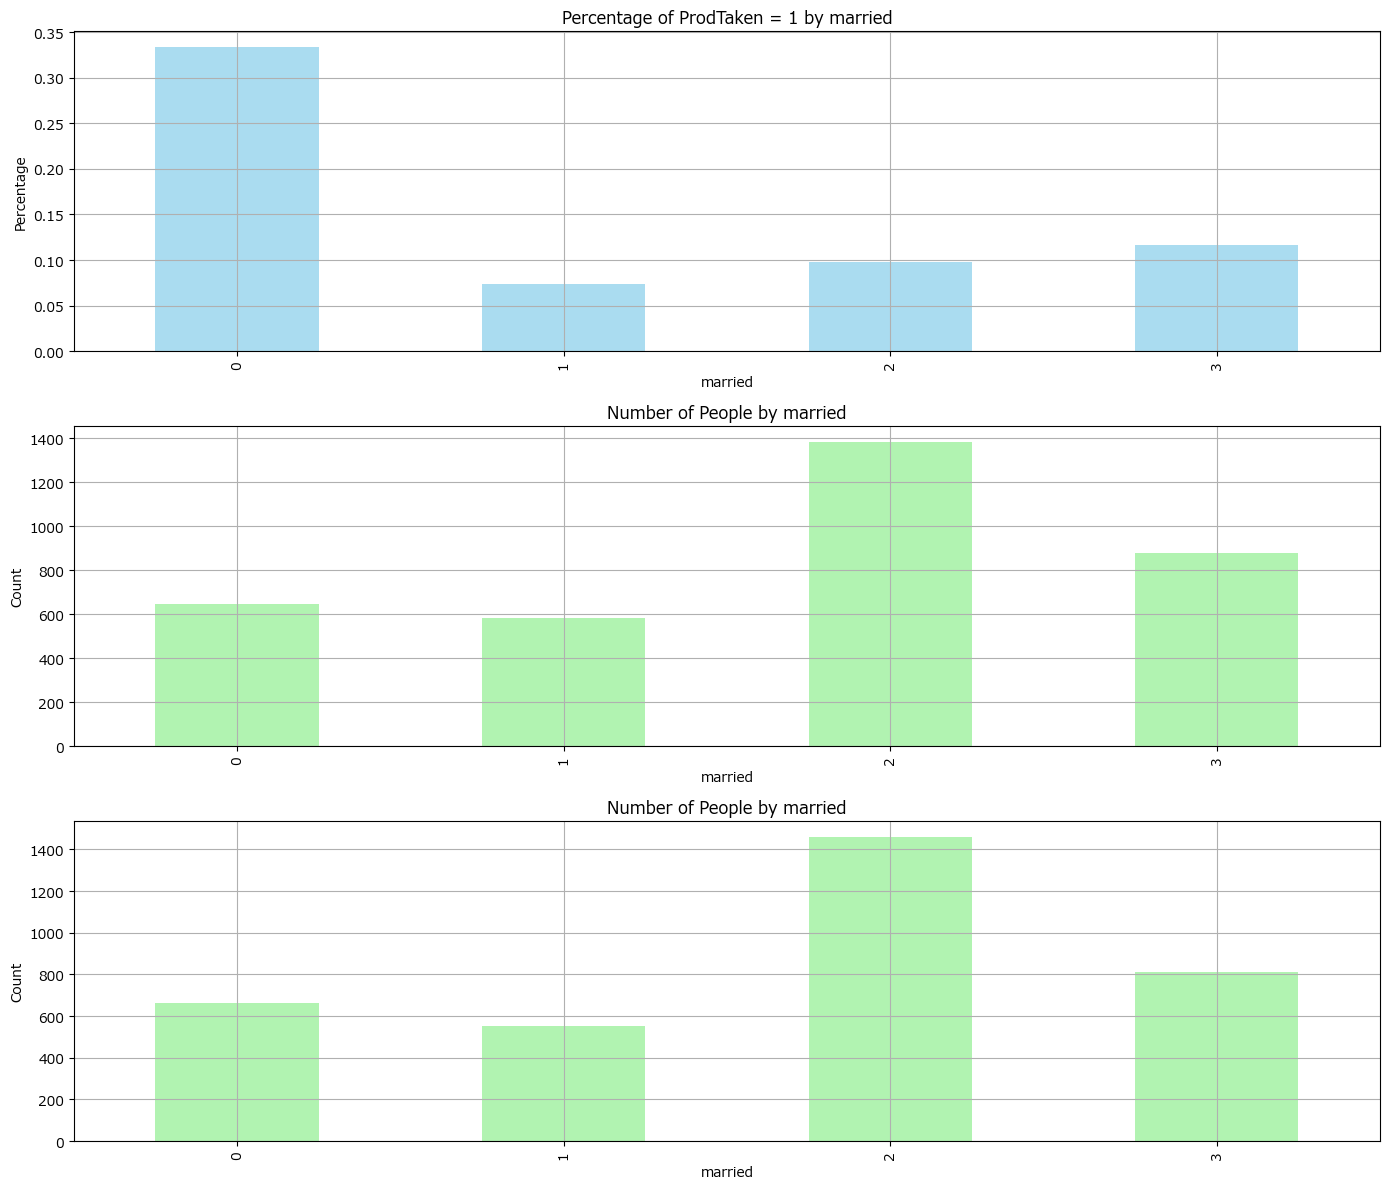

In [78]:
# married
frequency_plot('married')

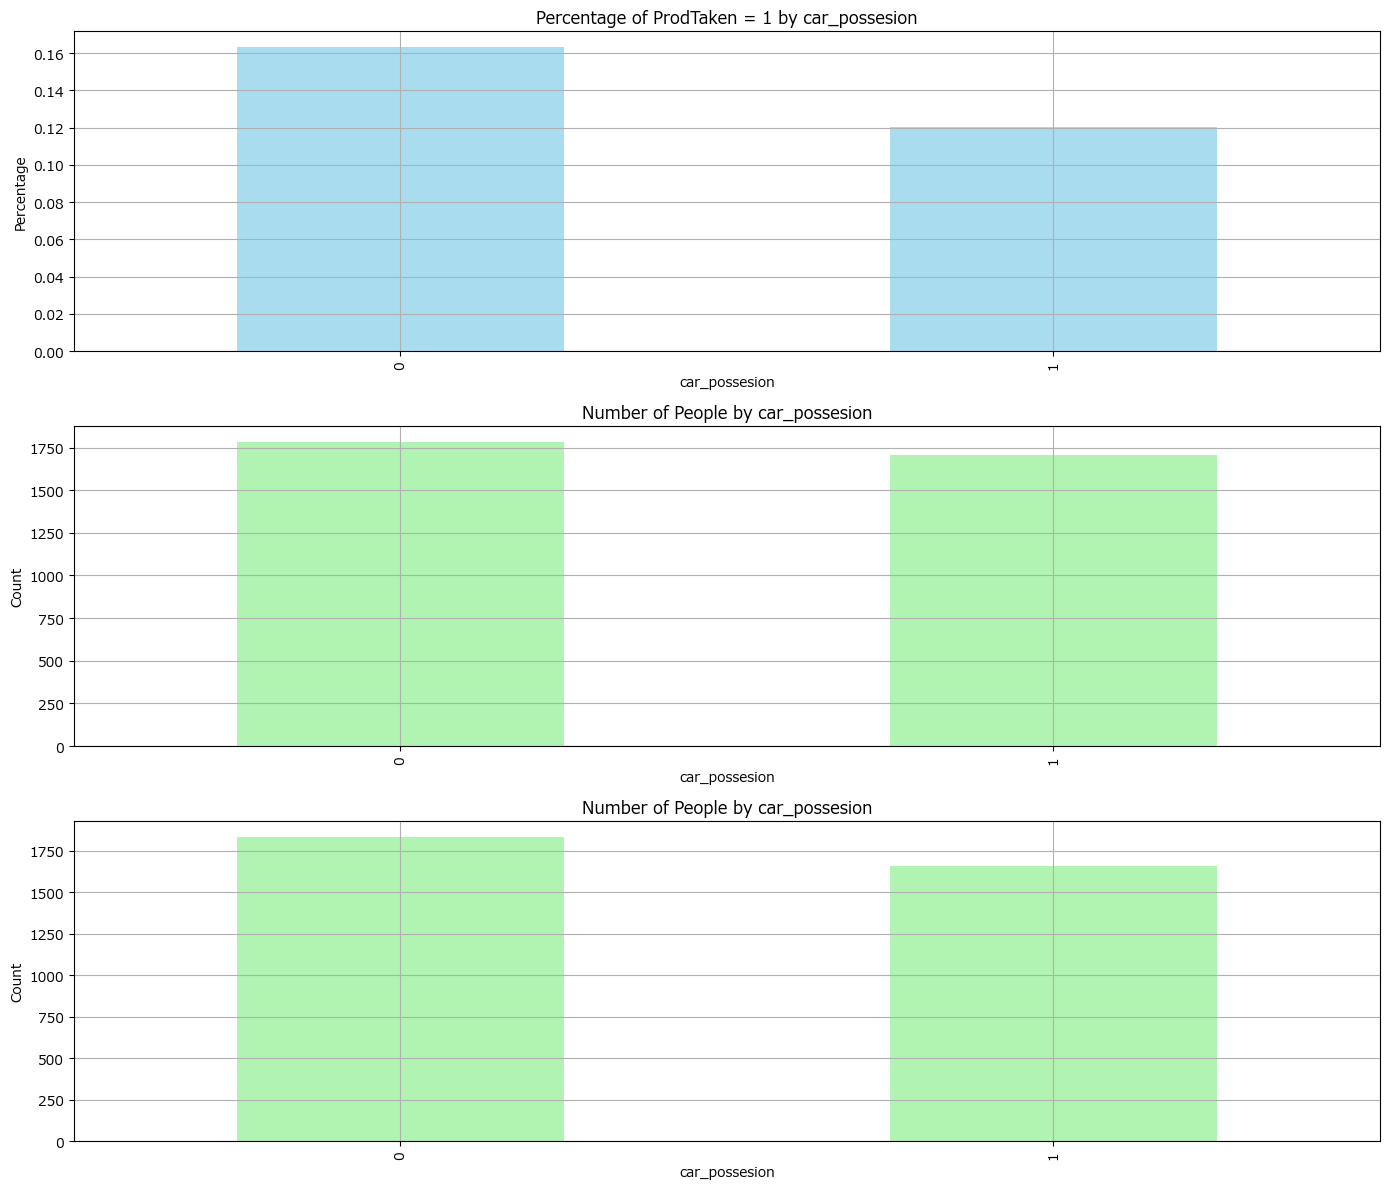

In [79]:
# car_possesion
frequency_plot('car_possesion')

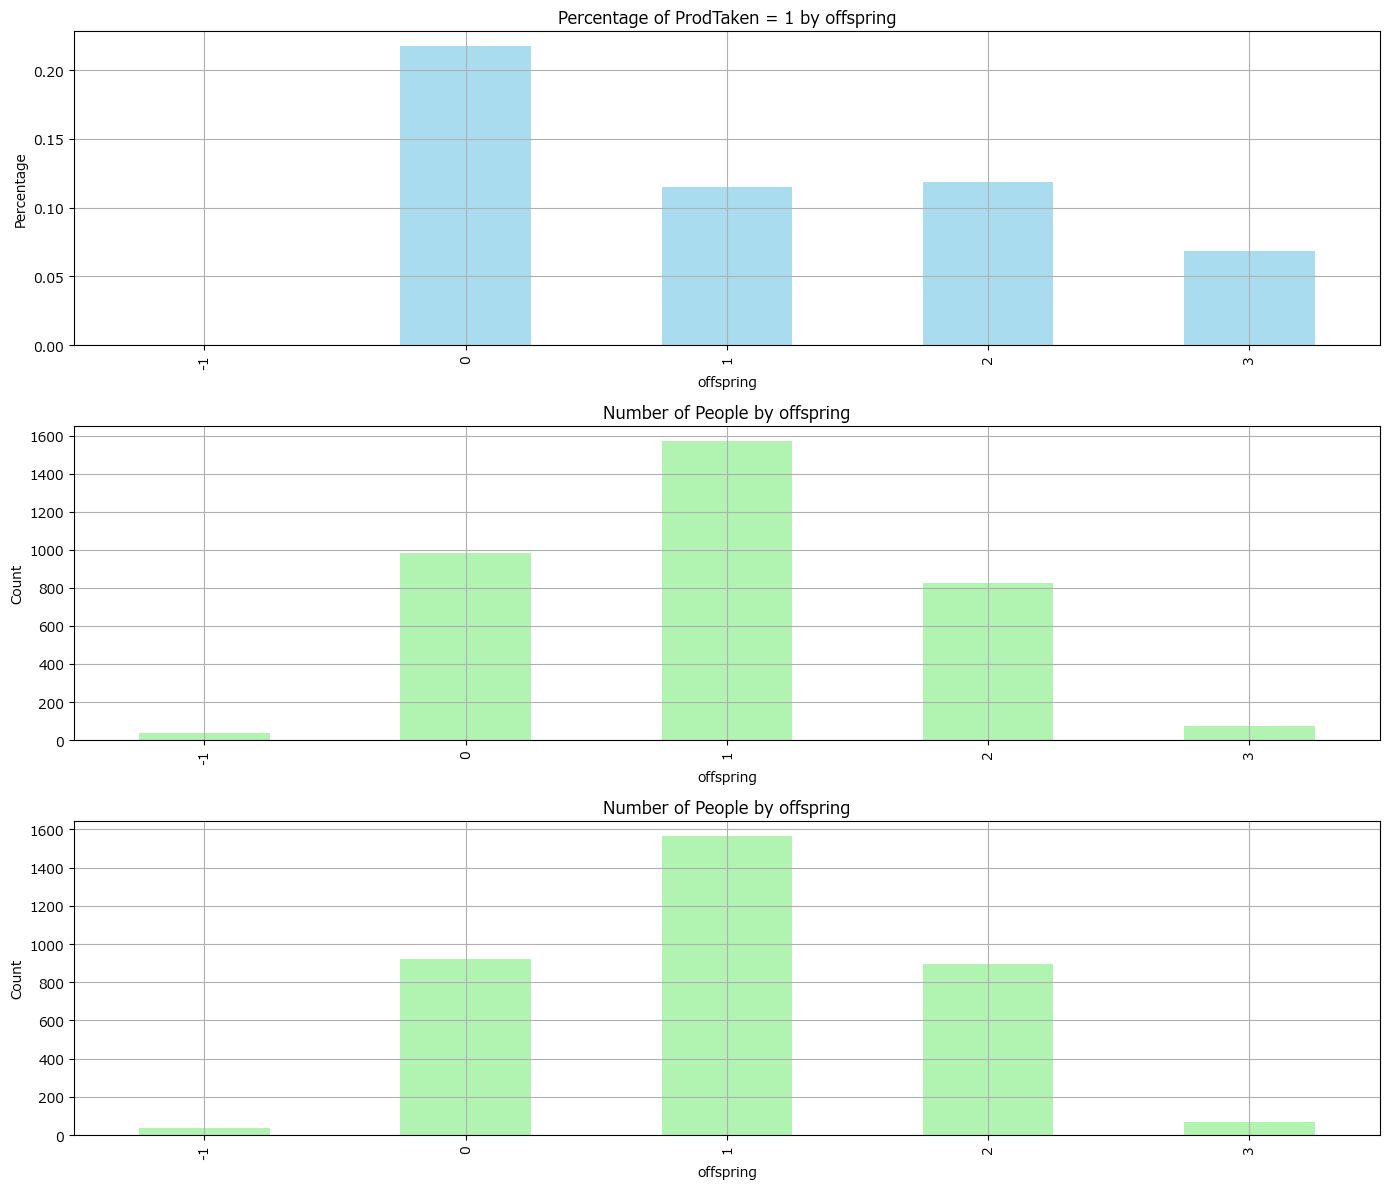

In [80]:
# offspring
frequency_plot('offspring')

In [43]:
# 変数名と列番号の対応を表示
col = pd.DataFrame(train1.columns.values).T
col

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,ProdTaken,married,car_possesion,offspring,IncomeBin


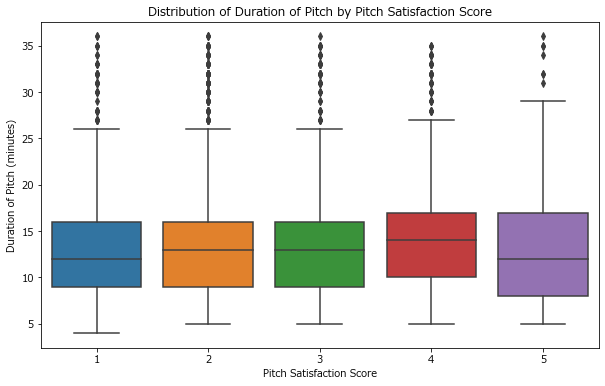

In [63]:
# 箱ひげ図で表示
plt.figure(figsize=(10, 6))
sns.boxplot(x='PitchSatisfactionScore', y='DurationOfPitch', data=train1)
plt.title('Distribution of Duration of Pitch by Pitch Satisfaction Score')
plt.xlabel('Pitch Satisfaction Score')
plt.ylabel('Duration of Pitch (minutes)')
plt.show()

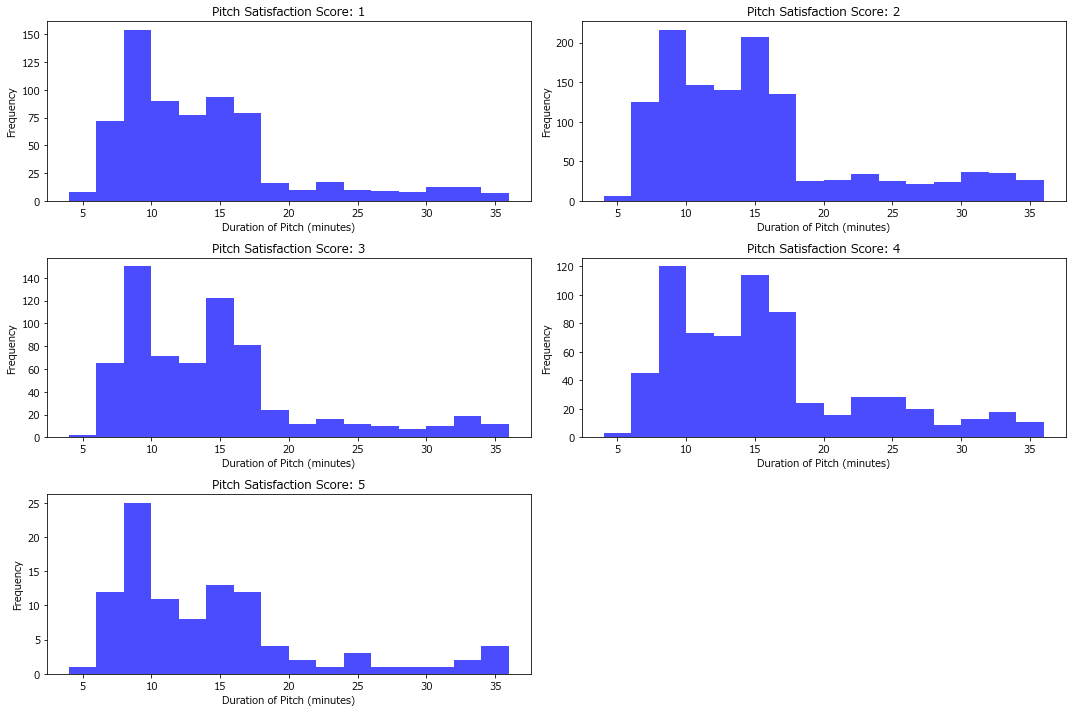

In [79]:
# 階級幅を2分間隔で設定
min_duration = train1['DurationOfPitch'].min()
max_duration = train1['DurationOfPitch'].max()
bins = list(range(int(min_duration), int(max_duration) + 2, 2))  # max + 2 で最後の階級を含める

# PitchSatisfactionScore の各値（1から5）ごとに別々のグラフを描く
scores = sorted(train1['PitchSatisfactionScore'].unique())  # Unique scores

plt.figure(figsize=(15, 10))  # 全体の図のサイズを設定

for i, score in enumerate(scores, 1):
    plt.subplot(3, 2, i)  # 3行2列のサブプロット
    subset = train1[train1['PitchSatisfactionScore'] == score]
    plt.hist(subset['DurationOfPitch'], bins=bins, alpha=0.7, color='blue')
    plt.title(f'Pitch Satisfaction Score: {score}')
    plt.xlabel('Duration of Pitch (minutes)')
    plt.ylabel('Frequency')
    plt.tight_layout()  # グラフ同士が重ならないようにレイアウトを調整

plt.show()

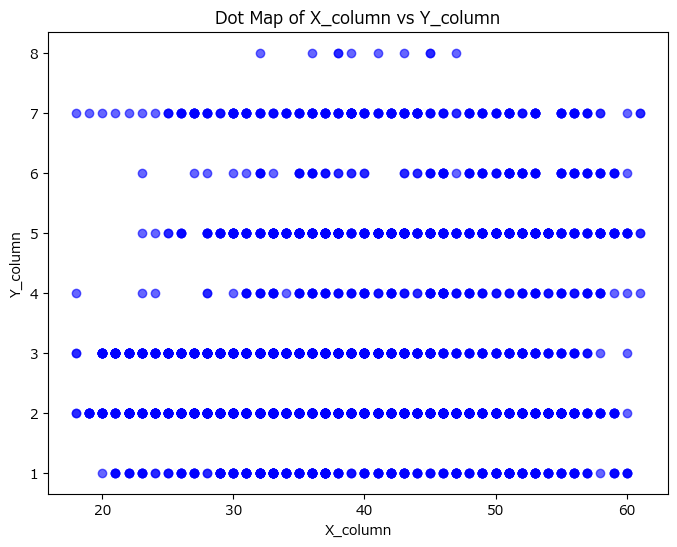

In [33]:
# ドットマップ（散布図）の作成
plt.figure(figsize=(8, 6))
plt.scatter(train1['Age'], train1['NumberOfTrips'], color='blue', alpha=0.6)

# グラフのタイトルとラベルの設定
plt.title('Dot Map of Age vs NumberOfTrips')
plt.xlabel('Age')
plt.ylabel('NumberOfTrips')

# グラフの表示
plt.show()

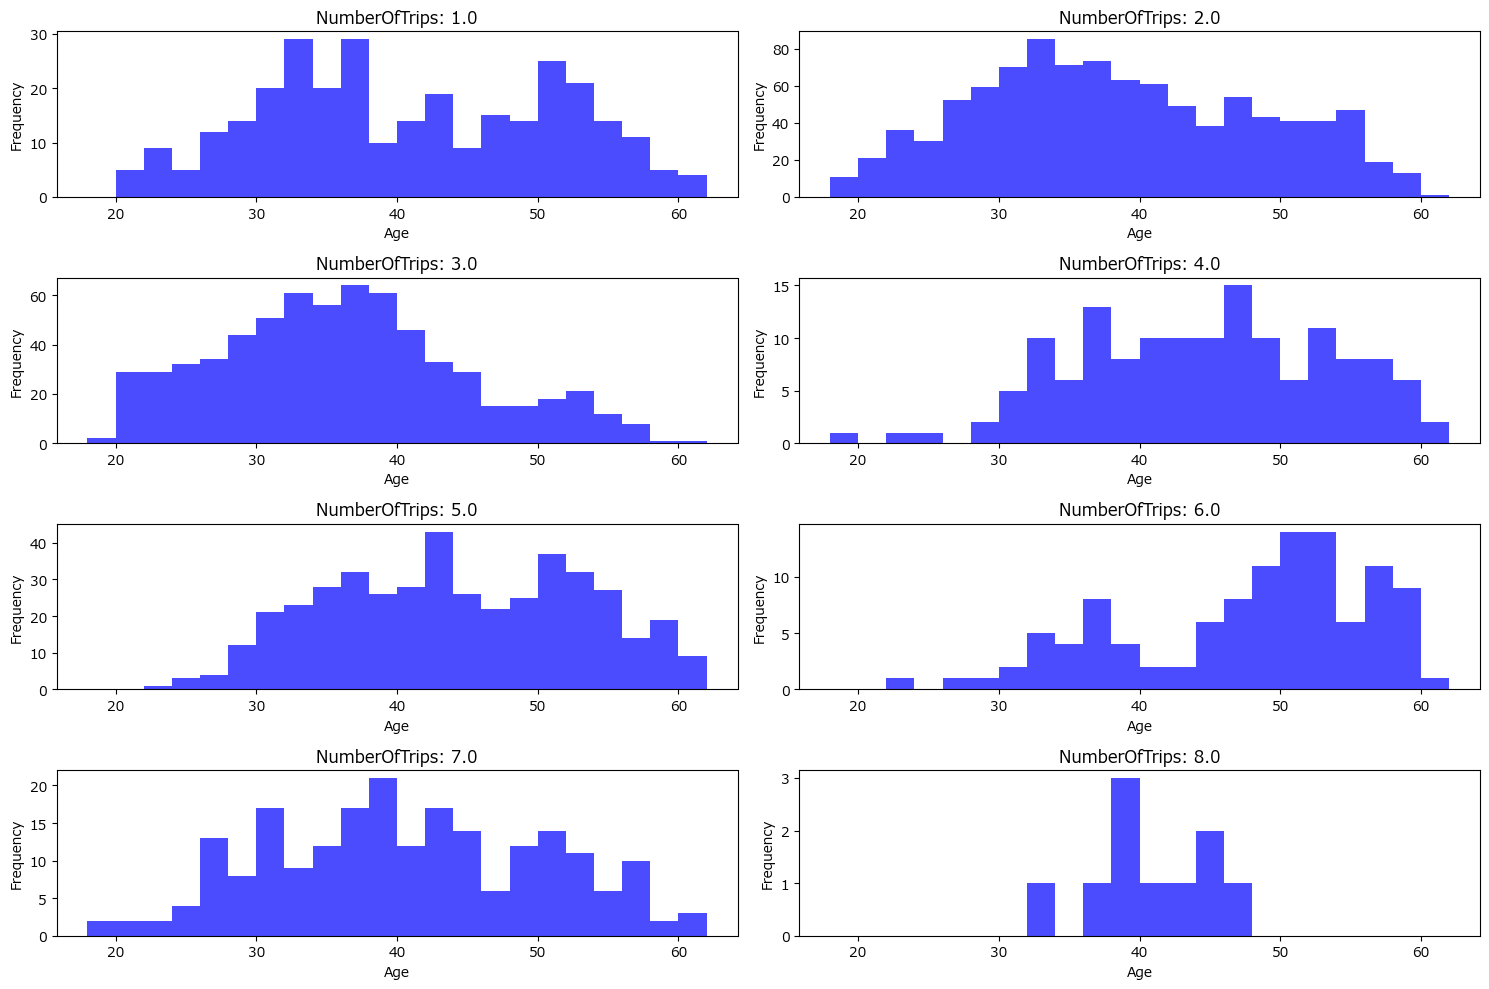

In [38]:
# 階級幅を2分間隔で設定
min_duration = train1['Age'].min()
max_duration = train1['Age'].max()
bins = list(range(int(min_duration), int(max_duration) + 2, 2))  # max + 2 で最後の階級を含める

# PitchSatisfactionScore の各値（1から5）ごとに別々のグラフを描く
scores = sorted(train1['NumberOfTrips'].unique())  # Unique scores

plt.figure(figsize=(15, 10))  # 全体の図のサイズを設定

for i, score in enumerate(scores, 1):
    plt.subplot(4, 2, i)  # 3行2列のサブプロット
    subset = train1[train1['NumberOfTrips'] == score]
    plt.hist(subset['Age'], bins=bins, alpha=0.7, color='blue')
    plt.title(f'NumberOfTrips: {score}')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.tight_layout()  # グラフ同士が重ならないようにレイアウトを調整

plt.show()

In [41]:
df = pd.concat([train1['PreferredPropertyStar'], train1['MonthlyIncome']], axis=1)
corr = df.corr()
corr

,PreferredPropertyStar,MonthlyIncome
PreferredPropertyStar,1.000000,0.178664
MonthlyIncome,0.178664,1.000000


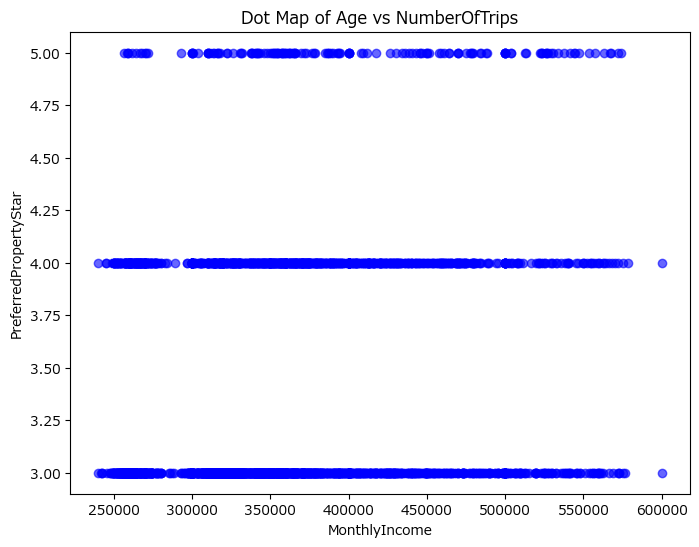

In [42]:
# ドットマップ（散布図）の作成
plt.figure(figsize=(8, 6))
plt.scatter(train1['MonthlyIncome'], train1['PreferredPropertyStar'], color='blue', alpha=0.6)

# グラフのタイトルとラベルの設定
plt.title('Dot Map of Age vs NumberOfTrips')
plt.xlabel('MonthlyIncome')
plt.ylabel('PreferredPropertyStar')

# グラフの表示
plt.show()

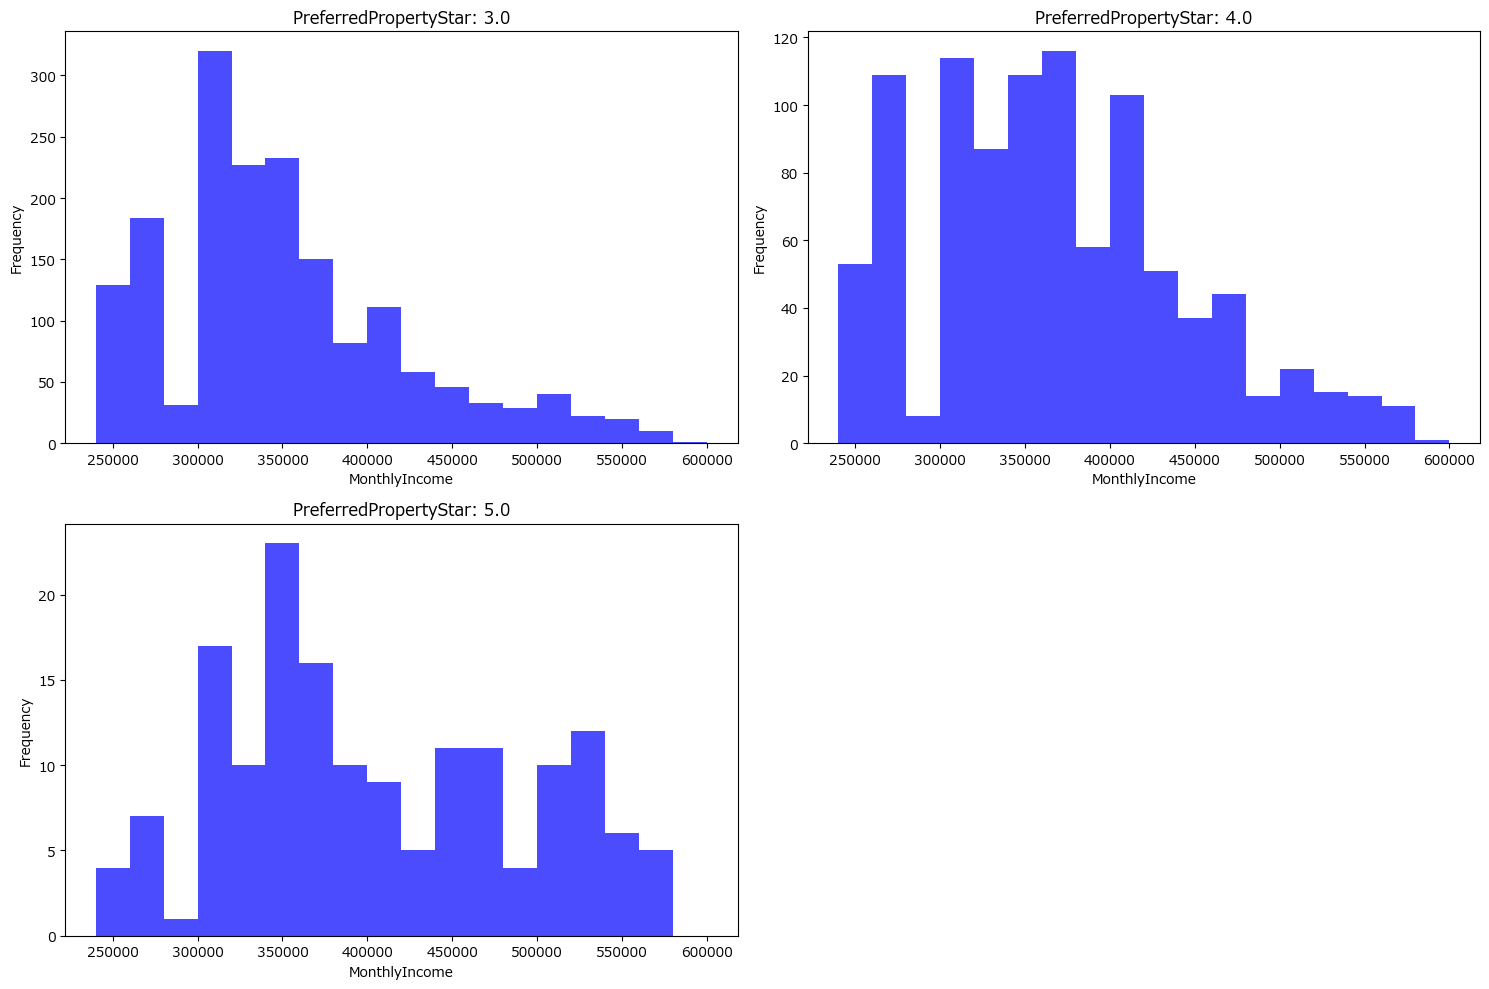

In [44]:
# 階級幅を2分間隔で設定
min_duration = train1['ProductPitched'].min()
max_duration = train1['ProductPitched'].max()
bins = list(range(int(min_duration), int(max_duration) + 20000, 20000))  # max + 2 で最後の階級を含める

# PitchSatisfactionScore の各値（1から5）ごとに別々のグラフを描く
scores = sorted(train1['PreferredPropertyStar'].unique())  # Unique scores

plt.figure(figsize=(15, 10))  # 全体の図のサイズを設定

for i, score in enumerate(scores, 1):
    plt.subplot(3, 2, i)  # 3行2列のサブプロット
    subset = train1[train1['PreferredPropertyStar'] == score]
    plt.hist(subset['ProductPitched'], bins=bins, alpha=0.7, color='blue')
    plt.title(f'PreferredPropertyStar: {score}')
    plt.xlabel('ProductPitched')
    plt.ylabel('Frequency')
    plt.tight_layout()  # グラフ同士が重ならないようにレイアウトを調整

plt.show()